In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from data_train_test import emo_utils
import random

In [3]:
epsilone = 0.000001

In [4]:
d50 =emo_utils.read_glove_vecs('glove.6B/glove.6B.50d.txt')
d100 = emo_utils.read_glove_vecs('glove.6B/glove.6B.100d.txt')

In [5]:
emo_utils.label_to_emoji(2)

'😄'

In [6]:
all_emoji = emo_utils.read_csv('data_train_test/emojify_data.csv')
train_emoji = emo_utils.read_csv('data_train_test/train_emoji.csv')
test_emoji = emo_utils.read_csv('data_train_test/test_emoji.csv')

In [7]:
train_Bow = np.array([[0]*400000])
for i in range(len(train_emoji[0])):
    words = train_emoji[0][i].split()
    BOW = np.array([[0]*400000 for _ in range(10)])
    for j in range(len(words)):
        BOW[j,d50[0][words[j].lower()]]=1
    train_Bow = np.concatenate((train_Bow,BOW), axis = 0)
train_Bow = np.delete(train_Bow, 0, axis = 0).reshape(132,10,400000)

test_Bow = np.array([[0]*400000])
for i in range(len(test_emoji[0])):
    words = test_emoji[0][i].split()
    BOW = np.array([[0]*400000 for _ in range(10)])
    for j in range(len(words)):
        BOW[j,d50[0][words[j].lower()]]=1
    test_Bow = np.concatenate((test_Bow,BOW), axis = 0)
test_Bow = np.delete(test_Bow, 0, axis = 0).reshape(56,10,400000)
    
print(np.shape(train_Bow))

(132, 10, 400000)


In [8]:
train_for_vec = []
for i in range(len(train_emoji[0])):
    words = train_emoji[0][i].split()
    train_for_vec.append(words)
    
test_for_vec = []
for i in range(len(test_emoji[0])):
    words = test_emoji[0][i].split()
    test_for_vec.append(words)

In [9]:
train_label = np.array([[0]*5 for _ in range(132)])
for i in range(132):
    train_label[i,train_emoji[1][i]]=1
    
test_label = np.array([[0]*5 for _ in range(132)])
for i in range(56):
    test_label[i,test_emoji[1][i]]=1

# 2 Design Recurrent Neural Network

In [10]:
class tanh():
    def forward(self, x):
        return (np.exp(x)-np.exp(-1*x))/(np.exp(x)+np.exp(-1*x))
    
    def backward(self, x):
        return 1-self.forward(x)**2

In [11]:
class sigmoid():
    def forward(self, x):
        return np.exp(x)/(np.exp(x)+1)
    
    def backward(self, x):
        return x*(1-x)

In [12]:
class Softmax_CE_loss():        
    def __init__(self):
        self.x = None
        self.t = None
        self.batch_size = None
        
    def forward(self,x,t):
        self.x = x
        self.t = t
        #overflow 방지
        x_wo_of = self.x - np.max(self.x)
        output = np.exp(x_wo_of)/np.sum(np.exp(x_wo_of))
        self.batch_size = x.shape[1]
        loss = (np.sum(-1*self.t*np.log(output+epsilone)))/self.batch_size
        return loss
    
    def backward(self):
        output = (self.x - self.t)/self.batch_size
        return output

In [13]:
class RNN():
    def __init__(self, learning_rate, batch_size, Bow_len, vector):
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.Bow_len = Bow_len
        self.vector = vector
        self.prev_h_t = np.random.randn(5, self.batch_size)*np.sqrt(1/25)
        # parameters 초기화
        self.W_hh = np.random.randn(5, 5)*np.sqrt(1/25)
        self.W_xh = np.random.randn(5, self.Bow_len)*np.sqrt(1/25)
        self.b_h = np.random.randn(5, 1)*np.sqrt(1/25)
        self.W_hy = np.random.randn(5, 5)*np.sqrt(1/25)
        self.b_y = np.random.randn(5, 1)*np.sqrt(1/25)
        # tanh, softmax 정의
        self.tanh = tanh()
        self.softmax = Softmax_CE_loss()
        self.information = None
        self.y_t = None
        
        self.first_moment = [0]*5
        self.second_moment = [0]*5
        self.first_unbias = [0]*5
        self.second_unbias = [0]*5
        self.count = 1
        
    def forward(self, x, y):
        self.information = []
        for i in range(len(x)):
            h_t = self.tanh.forward(self.W_hh.dot(self.prev_h_t) + self.W_xh.dot(self.vector[2][x[i].lower()][:,np.newaxis]) + self.b_h)
            # backpropagation에서 사용할 정보 저장 (매 layer의 x_t, h_t-1, h_t)
            self.information.append((self.vector[2][x[i].lower()][:,np.newaxis], self.prev_h_t, h_t))
            self.prev_h_t = h_t
        out = np.dot(self.W_hy, h_t) + self.b_y
        return out
        
    def backward(self):
        output_gradient = self.softmax.backward()
        dW_hh, dW_xh, dW_hy, db_h, db_y = np.zeros((5,5)), np.zeros((5,self.Bow_len)), np.zeros((5,5)), np.zeros((5,1)), np.zeros((5,1))
        # y_t = softmax( W_hy * h_t + b_y ) 의 backpropagation
        
        dW_hy += np.dot(output_gradient, self.information[-1][2].T)
        db_y += np.sum(output_gradient, keepdims = True, axis = -1)
        output_gradient = np.dot(self.W_hy.T, output_gradient)
            
        for i in range(len(self.information)-1, -1, -1):
            # h_t = tanh( W_hh * h_t-1 + W_hx * x_t + b_h ) 의 backpropagation
            # h_t와 output gradient를 받아와 tanh의 backward 진행      ( 1 - h_t**2 ) * output_gradient가 되어야한다.
            
            #output_gradient = self.tanh.backward(self.information[i][2]) * output_gradient
            output_gradient = (1 - self.information[i][2]**2) * output_gradient
            #output_gradient = self.tanh.backward(output_gradient)
            db_h += np.sum(output_gradient, keepdims = True, axis = -1)
            dW_hh += np.dot(output_gradient, self.information[i][1].T)
            dW_xh += np.dot(output_gradient, self.information[i][0].T)
            output_gradient = np.dot(self.W_hh.T, output_gradient)
            
        # dW_hh, dW_xh, dW_hy, db_h, db_y 순서로 tuple로 return (SGD나 ADAM으로 이어짐)
        return [dW_hh, dW_xh, dW_hy, db_h, db_y]
    
    def loss(self, x, y):
        out = self.forward(x,y)
        self.y_t = self.softmax.forward(out,y)
        return self.y_t
    
    def GD(self):
        # GD 함수를 사용하면 backward를 한 결과 gradient를 빼준다.
        gradient = self.backward()
        self.W_hh -= (self.learning_rate * gradient[0] / self.batch_size)
        self.W_xh -= (self.learning_rate * gradient[1] / self.batch_size)
        self.W_hy -= (self.learning_rate * gradient[2] / self.batch_size)
        self.b_h -= (self.learning_rate * gradient[3] / self.batch_size)
        self.b_y -= (self.learning_rate * gradient[4] / self.batch_size)
        
    def SGD(self,x,y):
        vec = np.zeros((10, self.batch_size, len(self.vector[2]['his'])))
        for i in range(self.batch_size):
            for j in range(len(x[i])):
                vec[j,i] = self.vector[2][x[i][j].lower()]
        self.information = []
        for i in range(self.batch_size):
            h_t = self.tanh.forward(self.W_hh.dot(self.prev_h_t) + self.W_xh.dot(vec[i].T) + self.b_h)
            # backpropagation에서 사용할 정보 저장 (매 layer의 x_t, h_t-1, h_t)
            self.information.append((vec[i].T, self.prev_h_t, h_t))
            self.prev_h_t = h_t
        out = np.dot(self.W_hy, h_t) + self.b_y
        self.y_t = self.softmax.forward(out,y.T)
        self.GD()
        return self.y_t
    
    def SGD_forward_only(self,x,y):
        vec = np.zeros((10, self.batch_size, len(self.vector[2]['his'])))
        for i in range(self.batch_size):
            for j in range(len(x[i])):
                vec[j,i] = self.vector[2][x[i][j].lower()]
        self.information = []
        for i in range(self.batch_size):
            h_t = self.tanh.forward(self.W_hh.dot(self.prev_h_t) + self.W_xh.dot(vec[i].T) + self.b_h)
            # backpropagation에서 사용할 정보 저장 (매 layer의 x_t, h_t-1, h_t)
            self.information.append((vec[i].T, self.prev_h_t, h_t))
            self.prev_h_t = h_t
        out = np.dot(self.W_hy, h_t) + self.b_y
        return out
        
    def Adam(self, beta1 = 0.9, beta2 = 0.999):
        gradient = self.backward()
        for i in range(len(gradient)):
            self.first_moment[i] = beta1 * self.first_moment[i] + (1-beta1)*gradient[i]
            self.second_moment[i] = beta2 * self.second_moment[i] + (1-beta2)*gradient[i]*gradient[i]
            self.first_unbias[i] = self.first_moment[i] / (1-beta1**self.count)
            self.second_unbias[i] = self.second_moment[i] / (1-beta2**self.count)
        self.W_hh -= (self.learning_rate * self.first_unbias[0]/(np.sqrt(self.second_unbias[0]+1e07)))
        self.W_xh -= (self.learning_rate * self.first_unbias[1]/(np.sqrt(self.second_unbias[1]+1e07)))
        self.W_hy -= (self.learning_rate * self.first_unbias[2]/(np.sqrt(self.second_unbias[2]+1e07)))
        self.b_h -= (self.learning_rate * self.first_unbias[3]/(np.sqrt(self.second_unbias[3]+1e07)))
        self.b_y -= (self.learning_rate * self.first_unbias[4]/(np.sqrt(self.second_unbias[4]+1e07)))
        self.count+=1

In [14]:
# Vanilla RNN + 50d + Adam optimizer

Rnn = RNN(0.1, 1, 50, d50)
correct = 0
train_loss =[] 
accuracy = []
test_loss = []
for j in range(1000):
    for i in range(132):
        loss = Rnn.loss(train_for_vec[i], train_label[i][:,np.newaxis])
        Rnn.Adam()
        if i==131:
            train_loss.append(loss)
    for i in range(56):
        out = Rnn.forward(test_for_vec[i], test_label[i][:,np.newaxis])
        if np.argmax(out) == np.argmax(test_label[i]):
            correct+=1
        if i == 55:
            loss = Rnn.loss(test_for_vec[i], test_label[i][:,np.newaxis])
            test_loss.append(loss)
    print(j+1,"번째 iter :",train_loss[j])
    print("Accuracy :",correct/56)
    accuracy.append(correct/56)
    correct = 0

1 번째 iter : 1.5526840945600262
Accuracy : 0.14285714285714285
2 번째 iter : 1.5512198157260813
Accuracy : 0.14285714285714285
3 번째 iter : 1.5497843819598744
Accuracy : 0.14285714285714285
4 번째 iter : 1.5483771801484512
Accuracy : 0.14285714285714285
5 번째 iter : 1.5469976110425416
Accuracy : 0.14285714285714285
6 번째 iter : 1.5456450889834656
Accuracy : 0.14285714285714285
7 번째 iter : 1.544319041638161
Accuracy : 0.14285714285714285
8 번째 iter : 1.5430189097349865
Accuracy : 0.14285714285714285
9 번째 iter : 1.541744146800643
Accuracy : 0.14285714285714285
10 번째 iter : 1.5404942188985131
Accuracy : 0.14285714285714285
11 번째 iter : 1.539268604368708
Accuracy : 0.14285714285714285
12 번째 iter : 1.5380667935700867
Accuracy : 0.14285714285714285
13 번째 iter : 1.5368882886244961
Accuracy : 0.14285714285714285
14 번째 iter : 1.5357326031634486
Accuracy : 0.14285714285714285
15 번째 iter : 1.5345992620774545
Accuracy : 0.14285714285714285
16 번째 iter : 1.5334878012681887
Accuracy : 0.14285714285714285
17 번

135 번째 iter : 1.482508292741617
Accuracy : 0.17857142857142858
136 번째 iter : 1.482418924710931
Accuracy : 0.17857142857142858
137 번째 iter : 1.4823321317391975
Accuracy : 0.17857142857142858
138 번째 iter : 1.4822478734802278
Accuracy : 0.17857142857142858
139 번째 iter : 1.4821661102241146
Accuracy : 0.17857142857142858
140 번째 iter : 1.4820868028855252
Accuracy : 0.17857142857142858
141 번째 iter : 1.4820099129922606
Accuracy : 0.16071428571428573
142 번째 iter : 1.4819354026740765
Accuracy : 0.16071428571428573
143 번째 iter : 1.4818632346517568
Accuracy : 0.16071428571428573
144 번째 iter : 1.4817933722264336
Accuracy : 0.16071428571428573
145 번째 iter : 1.4817257792691472
Accuracy : 0.16071428571428573
146 번째 iter : 1.481660420210639
Accuracy : 0.16071428571428573
147 번째 iter : 1.4815972600313718
Accuracy : 0.16071428571428573
148 번째 iter : 1.481536264251769
Accuracy : 0.16071428571428573
149 번째 iter : 1.4814773989226737
Accuracy : 0.16071428571428573
150 번째 iter : 1.4814206306160091
Accuracy : 

266 번째 iter : 1.4830459117085248
Accuracy : 0.17857142857142858
267 번째 iter : 1.4830963651124596
Accuracy : 0.17857142857142858
268 번째 iter : 1.483147064453765
Accuracy : 0.19642857142857142
269 번째 iter : 1.4831980038500436
Accuracy : 0.19642857142857142
270 번째 iter : 1.4832491775039678
Accuracy : 0.19642857142857142
271 번째 iter : 1.4833005797021008
Accuracy : 0.19642857142857142
272 번째 iter : 1.4833522048137375
Accuracy : 0.19642857142857142
273 번째 iter : 1.4834040472897592
Accuracy : 0.19642857142857142
274 번째 iter : 1.4834561016615058
Accuracy : 0.19642857142857142
275 번째 iter : 1.483508362539664
Accuracy : 0.19642857142857142
276 번째 iter : 1.4835608246131697
Accuracy : 0.19642857142857142
277 번째 iter : 1.4836134826481282
Accuracy : 0.19642857142857142
278 번째 iter : 1.4836663314867462
Accuracy : 0.19642857142857142
279 번째 iter : 1.4837193660462846
Accuracy : 0.19642857142857142
280 번째 iter : 1.4837725813180183
Accuracy : 0.19642857142857142
281 번째 iter : 1.4838259723662164
Accuracy 

412 번째 iter : 1.4911192963993667
Accuracy : 0.25
413 번째 iter : 1.4911715463853592
Accuracy : 0.25
414 번째 iter : 1.4912236958096605
Accuracy : 0.25
415 번째 iter : 1.4912757441489193
Accuracy : 0.25
416 번째 iter : 1.4913276908909825
Accuracy : 0.25
417 번째 iter : 1.4913795355347397
Accuracy : 0.25
418 번째 iter : 1.491431277589972
Accuracy : 0.25
419 번째 iter : 1.491482916577198
Accuracy : 0.25
420 번째 iter : 1.4915344520275244
Accuracy : 0.25
421 번째 iter : 1.4915858834825015
Accuracy : 0.25
422 번째 iter : 1.491637210493975
Accuracy : 0.25
423 번째 iter : 1.491688432623944
Accuracy : 0.25
424 번째 iter : 1.4917395494444194
Accuracy : 0.25
425 번째 iter : 1.491790560537284
Accuracy : 0.25
426 번째 iter : 1.4918414654941574
Accuracy : 0.25
427 번째 iter : 1.4918922639162562
Accuracy : 0.26785714285714285
428 번째 iter : 1.491942955414263
Accuracy : 0.26785714285714285
429 번째 iter : 1.491993539608195
Accuracy : 0.26785714285714285
430 번째 iter : 1.4920440161272714
Accuracy : 0.26785714285714285
431 번째 iter : 1.

546 번째 iter : 1.4971234425107705
Accuracy : 0.3392857142857143
547 번째 iter : 1.497160488402728
Accuracy : 0.3392857142857143
548 번째 iter : 1.4971974221749236
Accuracy : 0.3392857142857143
549 번째 iter : 1.4972342439775999
Accuracy : 0.3392857142857143
550 번째 iter : 1.4972709539625515
Accuracy : 0.3392857142857143
551 번째 iter : 1.4973075522830965
Accuracy : 0.3392857142857143
552 번째 iter : 1.4973440390940556
Accuracy : 0.3392857142857143
553 번째 iter : 1.4973804145517224
Accuracy : 0.3392857142857143
554 번째 iter : 1.4974166788138425
Accuracy : 0.3392857142857143
555 번째 iter : 1.4974528320395872
Accuracy : 0.3392857142857143
556 번째 iter : 1.497488874389531
Accuracy : 0.3392857142857143
557 번째 iter : 1.4975248060256265
Accuracy : 0.3392857142857143
558 번째 iter : 1.4975606271111825
Accuracy : 0.3392857142857143
559 번째 iter : 1.49759633781084
Accuracy : 0.35714285714285715
560 번째 iter : 1.4976319382905499
Accuracy : 0.35714285714285715
561 번째 iter : 1.49766742871755
Accuracy : 0.3571428571428

701 번째 iter : 1.5016413709097758
Accuracy : 0.375
702 번째 iter : 1.5016633567677777
Accuracy : 0.375
703 번째 iter : 1.5016852621459404
Accuracy : 0.375
704 번째 iter : 1.5017070872606326
Accuracy : 0.375
705 번째 iter : 1.5017288323280495
Accuracy : 0.375
706 번째 iter : 1.501750497564213
Accuracy : 0.375
707 번째 iter : 1.5017720831849635
Accuracy : 0.375
708 번째 iter : 1.5017935894059606
Accuracy : 0.375
709 번째 iter : 1.5018150164426776
Accuracy : 0.375
710 번째 iter : 1.501836364510399
Accuracy : 0.375
711 번째 iter : 1.5018576338242169
Accuracy : 0.375
712 번째 iter : 1.5018788245990284
Accuracy : 0.375
713 번째 iter : 1.5018999370495316
Accuracy : 0.375
714 번째 iter : 1.5019209713902228
Accuracy : 0.375
715 번째 iter : 1.5019419278353938
Accuracy : 0.375
716 번째 iter : 1.501962806599128
Accuracy : 0.375
717 번째 iter : 1.5019836078952988
Accuracy : 0.375
718 번째 iter : 1.502004331937565
Accuracy : 0.375
719 번째 iter : 1.5020249789393696
Accuracy : 0.375
720 번째 iter : 1.5020455491139348
Accuracy : 0.375
721 

864 번째 iter : 1.5043086510472015
Accuracy : 0.375
865 번째 iter : 1.5043201863997362
Accuracy : 0.375
866 번째 iter : 1.5043316727436036
Accuracy : 0.375
867 번째 iter : 1.504343110242935
Accuracy : 0.375
868 번째 iter : 1.5043544990614786
Accuracy : 0.375
869 번째 iter : 1.5043658393625998
Accuracy : 0.375
870 번째 iter : 1.5043771313092824
Accuracy : 0.375
871 번째 iter : 1.5043883750641263
Accuracy : 0.375
872 번째 iter : 1.5043995707893492
Accuracy : 0.375
873 번째 iter : 1.5044107186467859
Accuracy : 0.375
874 번째 iter : 1.5044218187978893
Accuracy : 0.375
875 번째 iter : 1.5044328714037287
Accuracy : 0.375
876 번째 iter : 1.5044438766249906
Accuracy : 0.375
877 번째 iter : 1.504454834621978
Accuracy : 0.375
878 번째 iter : 1.5044657455546118
Accuracy : 0.375
879 번째 iter : 1.5044766095824293
Accuracy : 0.375
880 번째 iter : 1.5044874268645858
Accuracy : 0.375
881 번째 iter : 1.5044981975598533
Accuracy : 0.375
882 번째 iter : 1.5045089218266194
Accuracy : 0.375
883 번째 iter : 1.5045195998228924
Accuracy : 0.375
88

Text(0.5, 1.0, 'RNN + 50d + Adam')

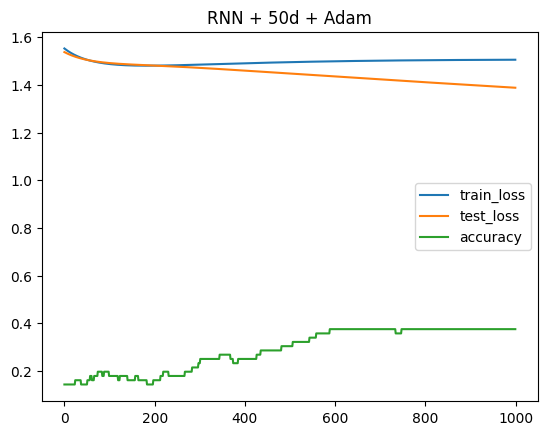

In [16]:
x = np.arange(1000)
plt.plot(x,train_loss, label = 'train_loss')
plt.plot(x,test_loss, label = 'test_loss')
plt.plot(x,accuracy, label = 'accuracy')
plt.legend()
plt.title("RNN + 50d + Adam")

In [19]:
# SGD 경사하강법

Rnn = RNN(0.05, 4, 50, d50)
correct = 0
train_loss =[] 
test_loss = []
accuracy = []
for j in range(5000):
    c = list(zip(train_for_vec, train_label))
    random.shuffle(c)
    train_for_vec, train_label = zip(*c)
    train_label = np.array(train_label)
    for i in range(132//4):
        loss = Rnn.SGD(train_for_vec[i*4:(i+1)*4], train_label[i*4:(i+1)*4])
        if i==132//4-1:
            train_loss.append(loss)
    for i in range(56//4):
        out = Rnn.SGD_forward_only(test_for_vec[i*4:(i+1)*4], test_label[i*4:(i+1)*4])
        correct += np.sum(np.argmax(out, axis =0) == np.argmax(test_label[i*4:(i+1)*4],axis=1))
        if i == 56//4-1:
            loss = Rnn.SGD(test_for_vec[i*4:(i+1)*4], test_label[i*4:(i+1)*4])
            test_loss.append(loss)
    print(j+1,"번째 iter :",train_loss[j])
    print("Accuracy :",correct/56)
    accuracy.append(correct/56)
    correct = 0

1 번째 iter : 2.841322425527755
Accuracy : 0.26785714285714285
2 번째 iter : 3.0150001678257774
Accuracy : 0.30357142857142855
3 번째 iter : 2.983427805632988
Accuracy : 0.30357142857142855
4 번째 iter : 2.921503864478111
Accuracy : 0.32142857142857145
5 번째 iter : 2.8452000115293528
Accuracy : 0.39285714285714285
6 번째 iter : 2.8774484873668578
Accuracy : 0.4107142857142857
7 번째 iter : 2.8800696176845157
Accuracy : 0.39285714285714285
8 번째 iter : 2.903199437259931
Accuracy : 0.39285714285714285
9 번째 iter : 2.9507123469260845
Accuracy : 0.375
10 번째 iter : 2.9630585476316846
Accuracy : 0.35714285714285715
11 번째 iter : 2.9009484987296545
Accuracy : 0.35714285714285715
12 번째 iter : 2.8187923847854868
Accuracy : 0.39285714285714285
13 번째 iter : 2.89128737639843
Accuracy : 0.4107142857142857
14 번째 iter : 2.868337696263569
Accuracy : 0.4107142857142857
15 번째 iter : 2.978776326023622
Accuracy : 0.4107142857142857
16 번째 iter : 2.9753319511002814
Accuracy : 0.375
17 번째 iter : 2.8157294860795914
Accuracy 

148 번째 iter : 2.6597384224017158
Accuracy : 0.5357142857142857
149 번째 iter : 2.810257051520036
Accuracy : 0.5357142857142857
150 번째 iter : 2.6626318257838886
Accuracy : 0.5357142857142857
151 번째 iter : 2.844762330363909
Accuracy : 0.5
152 번째 iter : 2.6048795233254074
Accuracy : 0.5178571428571429
153 번째 iter : 2.548401673962562
Accuracy : 0.5178571428571429
154 번째 iter : 2.6630926387202702
Accuracy : 0.5357142857142857
155 번째 iter : 2.651836572389268
Accuracy : 0.5178571428571429
156 번째 iter : 2.592487678939383
Accuracy : 0.5357142857142857
157 번째 iter : 2.7373870657301813
Accuracy : 0.5357142857142857
158 번째 iter : 2.5949706281008025
Accuracy : 0.5178571428571429
159 번째 iter : 2.7029342744063625
Accuracy : 0.44642857142857145
160 번째 iter : 2.614553497620539
Accuracy : 0.5178571428571429
161 번째 iter : 2.5577205308284467
Accuracy : 0.5357142857142857
162 번째 iter : 2.5881258465815584
Accuracy : 0.4642857142857143
163 번째 iter : 2.372566892984845
Accuracy : 0.5178571428571429
164 번째 iter :

296 번째 iter : 2.3589653944309115
Accuracy : 0.5357142857142857
297 번째 iter : 2.5753649799240113
Accuracy : 0.5892857142857143
298 번째 iter : 2.4768299347042073
Accuracy : 0.5357142857142857
299 번째 iter : 2.4819535300857662
Accuracy : 0.5178571428571429
300 번째 iter : 2.621226063769503
Accuracy : 0.5178571428571429
301 번째 iter : 2.4310814153636997
Accuracy : 0.5357142857142857
302 번째 iter : 2.5590849719931548
Accuracy : 0.5357142857142857
303 번째 iter : 2.582734516009479
Accuracy : 0.5357142857142857
304 번째 iter : 2.433822274406556
Accuracy : 0.5357142857142857
305 번째 iter : 2.413255886092234
Accuracy : 0.5357142857142857
306 번째 iter : 2.610723106388584
Accuracy : 0.5178571428571429
307 번째 iter : 2.5943587958075707
Accuracy : 0.5357142857142857
308 번째 iter : 2.4925872555275106
Accuracy : 0.5178571428571429
309 번째 iter : 2.424483934857818
Accuracy : 0.5535714285714286
310 번째 iter : 2.5940252723577704
Accuracy : 0.5178571428571429
311 번째 iter : 2.3086043649632026
Accuracy : 0.535714285714285

436 번째 iter : 2.612352247684138
Accuracy : 0.5714285714285714
437 번째 iter : 2.5489205396370203
Accuracy : 0.5535714285714286
438 번째 iter : 2.787998963840141
Accuracy : 0.5535714285714286
439 번째 iter : 2.532991887896795
Accuracy : 0.5535714285714286
440 번째 iter : 2.6002501776020237
Accuracy : 0.5535714285714286
441 번째 iter : 2.4245725848413566
Accuracy : 0.5535714285714286
442 번째 iter : 2.5313763850836137
Accuracy : 0.5714285714285714
443 번째 iter : 2.447541542818039
Accuracy : 0.5535714285714286
444 번째 iter : 2.521525516517782
Accuracy : 0.5714285714285714
445 번째 iter : 2.4662889633984393
Accuracy : 0.5535714285714286
446 번째 iter : 2.3180586631826294
Accuracy : 0.5535714285714286
447 번째 iter : 2.519543463482559
Accuracy : 0.5357142857142857
448 번째 iter : 2.531364546096544
Accuracy : 0.5535714285714286
449 번째 iter : 2.4004420843254346
Accuracy : 0.5357142857142857
450 번째 iter : 2.5815184217764218
Accuracy : 0.5535714285714286
451 번째 iter : 2.5600766999944207
Accuracy : 0.5178571428571429

573 번째 iter : 2.296669137760949
Accuracy : 0.5357142857142857
574 번째 iter : 2.455543725816235
Accuracy : 0.5892857142857143
575 번째 iter : 2.437467348021735
Accuracy : 0.5892857142857143
576 번째 iter : 2.451814919441513
Accuracy : 0.5892857142857143
577 번째 iter : 2.6529958554444995
Accuracy : 0.5714285714285714
578 번째 iter : 2.5678755740116
Accuracy : 0.5535714285714286
579 번째 iter : 2.3577914890959413
Accuracy : 0.5535714285714286
580 번째 iter : 2.334611120069277
Accuracy : 0.5714285714285714
581 번째 iter : 2.553761848482019
Accuracy : 0.5535714285714286
582 번째 iter : 2.523901436112019
Accuracy : 0.5535714285714286
583 번째 iter : 2.6247224179492177
Accuracy : 0.5892857142857143
584 번째 iter : 2.3678483787563818
Accuracy : 0.5892857142857143
585 번째 iter : 2.570317745184262
Accuracy : 0.5714285714285714
586 번째 iter : 2.4191894320374376
Accuracy : 0.5714285714285714
587 번째 iter : 2.4211316470116317
Accuracy : 0.5535714285714286
588 번째 iter : 2.4234556689168363
Accuracy : 0.5892857142857143
589

705 번째 iter : 2.563214813224179
Accuracy : 0.5535714285714286
706 번째 iter : 2.3970660420494068
Accuracy : 0.5714285714285714
707 번째 iter : 2.38988966991986
Accuracy : 0.5535714285714286
708 번째 iter : 2.5248037830165737
Accuracy : 0.5535714285714286
709 번째 iter : 2.379470034075224
Accuracy : 0.5714285714285714
710 번째 iter : 2.4369520260687683
Accuracy : 0.5714285714285714
711 번째 iter : 2.549395044194922
Accuracy : 0.5535714285714286
712 번째 iter : 2.4034244981613293
Accuracy : 0.5357142857142857
713 번째 iter : 2.432881827237619
Accuracy : 0.5714285714285714
714 번째 iter : 2.539003870075801
Accuracy : 0.5714285714285714
715 번째 iter : 2.4294469851070364
Accuracy : 0.5714285714285714
716 번째 iter : 2.372924522141209
Accuracy : 0.5714285714285714
717 번째 iter : 2.368966411838273
Accuracy : 0.5535714285714286
718 번째 iter : 2.3454640146797154
Accuracy : 0.5892857142857143
719 번째 iter : 2.5626298550340776
Accuracy : 0.5714285714285714
720 번째 iter : 2.628922651097012
Accuracy : 0.5714285714285714
72

841 번째 iter : 2.3681499713371945
Accuracy : 0.5714285714285714
842 번째 iter : 2.486497844924313
Accuracy : 0.5892857142857143
843 번째 iter : 2.388692877746024
Accuracy : 0.5535714285714286
844 번째 iter : 2.5128510270585425
Accuracy : 0.5535714285714286
845 번째 iter : 2.4634372338940613
Accuracy : 0.5714285714285714
846 번째 iter : 2.5345137085925122
Accuracy : 0.5535714285714286
847 번째 iter : 2.6478016719487707
Accuracy : 0.5535714285714286
848 번째 iter : 2.3943828233806874
Accuracy : 0.5892857142857143
849 번째 iter : 2.4019612460266413
Accuracy : 0.5714285714285714
850 번째 iter : 2.5532324861509825
Accuracy : 0.5892857142857143
851 번째 iter : 2.483505584918057
Accuracy : 0.5714285714285714
852 번째 iter : 2.3728258363489374
Accuracy : 0.5892857142857143
853 번째 iter : 2.316384345551187
Accuracy : 0.6071428571428571
854 번째 iter : 2.3794663410376256
Accuracy : 0.5535714285714286
855 번째 iter : 2.4385904897162867
Accuracy : 0.5892857142857143
856 번째 iter : 2.557507364173084
Accuracy : 0.60714285714285

989 번째 iter : 2.392590090577057
Accuracy : 0.5535714285714286
990 번째 iter : 2.4886518019424395
Accuracy : 0.5714285714285714
991 번째 iter : 2.424664644312219
Accuracy : 0.5535714285714286
992 번째 iter : 2.4610648982710526
Accuracy : 0.5892857142857143
993 번째 iter : 2.4769364498501485
Accuracy : 0.5535714285714286
994 번째 iter : 2.463666358395814
Accuracy : 0.5892857142857143
995 번째 iter : 2.34322425264296
Accuracy : 0.5535714285714286
996 번째 iter : 2.437269844120853
Accuracy : 0.5714285714285714
997 번째 iter : 2.433061095308528
Accuracy : 0.5714285714285714
998 번째 iter : 2.580404262371441
Accuracy : 0.5714285714285714
999 번째 iter : 2.482347830253805
Accuracy : 0.5714285714285714
1000 번째 iter : 2.4757466287235057
Accuracy : 0.5714285714285714
1001 번째 iter : 2.373075308346385
Accuracy : 0.5714285714285714
1002 번째 iter : 2.4174175728892546
Accuracy : 0.5892857142857143
1003 번째 iter : 2.3860598259145185
Accuracy : 0.5892857142857143
1004 번째 iter : 2.3716313297014433
Accuracy : 0.57142857142857

1133 번째 iter : 2.453200409710483
Accuracy : 0.5357142857142857
1134 번째 iter : 2.4110288240576976
Accuracy : 0.5357142857142857
1135 번째 iter : 2.440341652823964
Accuracy : 0.5357142857142857
1136 번째 iter : 2.4400393592317844
Accuracy : 0.5714285714285714
1137 번째 iter : 2.393327148784086
Accuracy : 0.5535714285714286
1138 번째 iter : 2.462589624597088
Accuracy : 0.5535714285714286
1139 번째 iter : 2.4801359155367875
Accuracy : 0.5535714285714286
1140 번째 iter : 2.484467370380999
Accuracy : 0.5357142857142857
1141 번째 iter : 2.675418522373568
Accuracy : 0.5535714285714286
1142 번째 iter : 2.3914963787042813
Accuracy : 0.5535714285714286
1143 번째 iter : 2.3885125488851315
Accuracy : 0.5535714285714286
1144 번째 iter : 2.5392968246244862
Accuracy : 0.5535714285714286
1145 번째 iter : 2.3850165553485416
Accuracy : 0.5714285714285714
1146 번째 iter : 2.449283413502733
Accuracy : 0.5357142857142857
1147 번째 iter : 2.5979807863521476
Accuracy : 0.5535714285714286
1148 번째 iter : 2.3188909944848275
Accuracy : 0.

1281 번째 iter : 2.4058564008695447
Accuracy : 0.5535714285714286
1282 번째 iter : 2.4189766430647635
Accuracy : 0.5535714285714286
1283 번째 iter : 2.4348881464590435
Accuracy : 0.5535714285714286
1284 번째 iter : 2.28232082331239
Accuracy : 0.5714285714285714
1285 번째 iter : 2.3417041650036334
Accuracy : 0.5714285714285714
1286 번째 iter : 2.6009766367553935
Accuracy : 0.5357142857142857
1287 번째 iter : 2.380251982705934
Accuracy : 0.5535714285714286
1288 번째 iter : 2.4457623686963266
Accuracy : 0.5357142857142857
1289 번째 iter : 2.345061603165576
Accuracy : 0.5357142857142857
1290 번째 iter : 2.560368680766662
Accuracy : 0.5178571428571429
1291 번째 iter : 2.526835211605658
Accuracy : 0.5357142857142857
1292 번째 iter : 2.3435331235751846
Accuracy : 0.5535714285714286
1293 번째 iter : 2.3919508998124175
Accuracy : 0.5357142857142857
1294 번째 iter : 2.443069702765526
Accuracy : 0.5178571428571429
1295 번째 iter : 2.4147973685496895
Accuracy : 0.5357142857142857
1296 번째 iter : 2.597837870072173
Accuracy : 0.5

1421 번째 iter : 2.3695568850286977
Accuracy : 0.5357142857142857
1422 번째 iter : 2.449439595080461
Accuracy : 0.5535714285714286
1423 번째 iter : 2.46936859823208
Accuracy : 0.5535714285714286
1424 번째 iter : 2.246398048486215
Accuracy : 0.5535714285714286
1425 번째 iter : 2.3386733399995614
Accuracy : 0.5178571428571429
1426 번째 iter : 2.4260420640269342
Accuracy : 0.5357142857142857
1427 번째 iter : 2.417354355217154
Accuracy : 0.5535714285714286
1428 번째 iter : 2.361640633999272
Accuracy : 0.5178571428571429
1429 번째 iter : 2.5355407961193173
Accuracy : 0.5535714285714286
1430 번째 iter : 2.4136828481489365
Accuracy : 0.5357142857142857
1431 번째 iter : 2.5068421559569742
Accuracy : 0.5357142857142857
1432 번째 iter : 2.39031591449698
Accuracy : 0.5357142857142857
1433 번째 iter : 2.492232124885036
Accuracy : 0.5535714285714286
1434 번째 iter : 2.4670771150111075
Accuracy : 0.5535714285714286
1435 번째 iter : 2.512014752683328
Accuracy : 0.5357142857142857
1436 번째 iter : 2.468466712707357
Accuracy : 0.5357

1566 번째 iter : 2.3556329053843146
Accuracy : 0.5357142857142857
1567 번째 iter : 2.393427356507136
Accuracy : 0.5178571428571429
1568 번째 iter : 2.403191074915619
Accuracy : 0.5357142857142857
1569 번째 iter : 2.4447888201141943
Accuracy : 0.5178571428571429
1570 번째 iter : 2.4189115168560997
Accuracy : 0.5178571428571429
1571 번째 iter : 2.298143720903388
Accuracy : 0.5178571428571429
1572 번째 iter : 2.3603895363632255
Accuracy : 0.5
1573 번째 iter : 2.3448374665375065
Accuracy : 0.5357142857142857
1574 번째 iter : 2.387161117808709
Accuracy : 0.5357142857142857
1575 번째 iter : 2.492706641205473
Accuracy : 0.5178571428571429
1576 번째 iter : 2.6246216715019024
Accuracy : 0.5357142857142857
1577 번째 iter : 2.3177331358221247
Accuracy : 0.5178571428571429
1578 번째 iter : 2.4180864827080617
Accuracy : 0.5178571428571429
1579 번째 iter : 2.323568514178235
Accuracy : 0.5357142857142857
1580 번째 iter : 2.4546982672316435
Accuracy : 0.5178571428571429
1581 번째 iter : 2.4236530263952445
Accuracy : 0.51785714285714

1702 번째 iter : 2.3678353212109693
Accuracy : 0.5357142857142857
1703 번째 iter : 2.318529105468153
Accuracy : 0.5178571428571429
1704 번째 iter : 2.356699634829792
Accuracy : 0.5357142857142857
1705 번째 iter : 2.3668241704697643
Accuracy : 0.5357142857142857
1706 번째 iter : 2.308794331659147
Accuracy : 0.5357142857142857
1707 번째 iter : 2.3476174205593816
Accuracy : 0.5357142857142857
1708 번째 iter : 2.5979082413809564
Accuracy : 0.5178571428571429
1709 번째 iter : 2.2964317318179304
Accuracy : 0.5357142857142857
1710 번째 iter : 2.4026694857112223
Accuracy : 0.5357142857142857
1711 번째 iter : 2.3569700232027597
Accuracy : 0.5357142857142857
1712 번째 iter : 2.4153029663355765
Accuracy : 0.5357142857142857
1713 번째 iter : 2.418499180909451
Accuracy : 0.5357142857142857
1714 번째 iter : 2.391116720230485
Accuracy : 0.5357142857142857
1715 번째 iter : 2.3974232471313153
Accuracy : 0.5178571428571429
1716 번째 iter : 2.4143093901474986
Accuracy : 0.5178571428571429
1717 번째 iter : 2.4785269211160257
Accuracy : 

1842 번째 iter : 2.408821437866961
Accuracy : 0.5
1843 번째 iter : 2.3215055706186356
Accuracy : 0.5357142857142857
1844 번째 iter : 2.325983796840164
Accuracy : 0.5357142857142857
1845 번째 iter : 2.351392758415751
Accuracy : 0.5
1846 번째 iter : 2.3233610747790108
Accuracy : 0.5357142857142857
1847 번째 iter : 2.3945443050234543
Accuracy : 0.5
1848 번째 iter : 2.4048514306662128
Accuracy : 0.5
1849 번째 iter : 2.333173113894727
Accuracy : 0.5
1850 번째 iter : 2.5368207722620255
Accuracy : 0.5178571428571429
1851 번째 iter : 2.5339706227251986
Accuracy : 0.5
1852 번째 iter : 2.407387986259986
Accuracy : 0.5357142857142857
1853 번째 iter : 2.336498876934634
Accuracy : 0.5178571428571429
1854 번째 iter : 2.415998535671359
Accuracy : 0.5178571428571429
1855 번째 iter : 2.3969222337689753
Accuracy : 0.5178571428571429
1856 번째 iter : 2.385725704797841
Accuracy : 0.5
1857 번째 iter : 2.496177855636801
Accuracy : 0.5
1858 번째 iter : 2.3742264664388992
Accuracy : 0.5178571428571429
1859 번째 iter : 2.2458408777919683
Accurac

1990 번째 iter : 2.405033433275955
Accuracy : 0.5
1991 번째 iter : 2.3373597685832768
Accuracy : 0.5
1992 번째 iter : 2.3972261272821913
Accuracy : 0.5
1993 번째 iter : 2.3388542021853502
Accuracy : 0.5
1994 번째 iter : 2.349206364413086
Accuracy : 0.5178571428571429
1995 번째 iter : 2.4405311284578435
Accuracy : 0.5
1996 번째 iter : 2.465690289325935
Accuracy : 0.5178571428571429
1997 번째 iter : 2.392476911440108
Accuracy : 0.5
1998 번째 iter : 2.3829499555264793
Accuracy : 0.5178571428571429
1999 번째 iter : 2.403336248408622
Accuracy : 0.5178571428571429
2000 번째 iter : 2.409203051519844
Accuracy : 0.5178571428571429
2001 번째 iter : 2.434401769079323
Accuracy : 0.48214285714285715
2002 번째 iter : 2.361524666592696
Accuracy : 0.5
2003 번째 iter : 2.523131305945504
Accuracy : 0.5178571428571429
2004 번째 iter : 2.43448191863934
Accuracy : 0.5178571428571429
2005 번째 iter : 2.4265501666530733
Accuracy : 0.5
2006 번째 iter : 2.249105308387449
Accuracy : 0.5
2007 번째 iter : 2.342936757203802
Accuracy : 0.5
2008 번째 it

2140 번째 iter : 2.3656912754631385
Accuracy : 0.48214285714285715
2141 번째 iter : 2.3334748450845266
Accuracy : 0.5
2142 번째 iter : 2.376219866220816
Accuracy : 0.48214285714285715
2143 번째 iter : 2.413509075077819
Accuracy : 0.48214285714285715
2144 번째 iter : 2.3238858718597
Accuracy : 0.5
2145 번째 iter : 2.4039483260360495
Accuracy : 0.5
2146 번째 iter : 2.4095236629382644
Accuracy : 0.5
2147 번째 iter : 2.392348019245175
Accuracy : 0.48214285714285715
2148 번째 iter : 2.3644518426677994
Accuracy : 0.5
2149 번째 iter : 2.361874460108595
Accuracy : 0.5
2150 번째 iter : 2.3473703259718675
Accuracy : 0.48214285714285715
2151 번째 iter : 2.35886369333308
Accuracy : 0.48214285714285715
2152 번째 iter : 2.386643542136018
Accuracy : 0.48214285714285715
2153 번째 iter : 2.327092072026534
Accuracy : 0.48214285714285715
2154 번째 iter : 2.5486298592254575
Accuracy : 0.5
2155 번째 iter : 2.3592314517493236
Accuracy : 0.5
2156 번째 iter : 2.4059581960876413
Accuracy : 0.48214285714285715
2157 번째 iter : 2.3775309098242126


2301 번째 iter : 2.328502012792797
Accuracy : 0.5
2302 번째 iter : 2.440059381730275
Accuracy : 0.48214285714285715
2303 번째 iter : 2.4455187724505434
Accuracy : 0.48214285714285715
2304 번째 iter : 2.503840896870108
Accuracy : 0.5
2305 번째 iter : 2.41640138926455
Accuracy : 0.5
2306 번째 iter : 2.392918142122246
Accuracy : 0.5
2307 번째 iter : 2.3758811406082483
Accuracy : 0.5178571428571429
2308 번째 iter : 2.361886412210261
Accuracy : 0.5
2309 번째 iter : 2.4649292800948617
Accuracy : 0.5178571428571429
2310 번째 iter : 2.5343170327823805
Accuracy : 0.5178571428571429
2311 번째 iter : 2.335494041345598
Accuracy : 0.48214285714285715
2312 번째 iter : 2.3311876844532207
Accuracy : 0.48214285714285715
2313 번째 iter : 2.471963924600445
Accuracy : 0.5
2314 번째 iter : 2.3425254403486893
Accuracy : 0.5
2315 번째 iter : 2.353420318003688
Accuracy : 0.5
2316 번째 iter : 2.4440270928332106
Accuracy : 0.48214285714285715
2317 번째 iter : 2.4267472451549095
Accuracy : 0.48214285714285715
2318 번째 iter : 2.328014044682722
Acc

2464 번째 iter : 2.3290382452735603
Accuracy : 0.48214285714285715
2465 번째 iter : 2.3625750049507563
Accuracy : 0.48214285714285715
2466 번째 iter : 2.4517989152904076
Accuracy : 0.5
2467 번째 iter : 2.3386303901241234
Accuracy : 0.5
2468 번째 iter : 2.401074885096109
Accuracy : 0.5
2469 번째 iter : 2.4100145004487183
Accuracy : 0.48214285714285715
2470 번째 iter : 2.47375652378203
Accuracy : 0.48214285714285715
2471 번째 iter : 2.311170995145892
Accuracy : 0.5
2472 번째 iter : 2.408911228132782
Accuracy : 0.5
2473 번째 iter : 2.366084900814426
Accuracy : 0.5
2474 번째 iter : 2.492068326347293
Accuracy : 0.5
2475 번째 iter : 2.323284796118621
Accuracy : 0.48214285714285715
2476 번째 iter : 2.420785572702893
Accuracy : 0.5
2477 번째 iter : 2.4420650349038713
Accuracy : 0.5
2478 번째 iter : 2.3644503868764772
Accuracy : 0.5
2479 번째 iter : 2.357450522815399
Accuracy : 0.48214285714285715
2480 번째 iter : 2.4259606457072778
Accuracy : 0.5
2481 번째 iter : 2.3713610876604014
Accuracy : 0.48214285714285715
2482 번째 iter : 2

2618 번째 iter : 2.3226459051639248
Accuracy : 0.48214285714285715
2619 번째 iter : 2.5144201592011144
Accuracy : 0.48214285714285715
2620 번째 iter : 2.3815327763278833
Accuracy : 0.48214285714285715
2621 번째 iter : 2.3372730164182114
Accuracy : 0.48214285714285715
2622 번째 iter : 2.4241864366564396
Accuracy : 0.48214285714285715
2623 번째 iter : 2.3596615737194537
Accuracy : 0.4642857142857143
2624 번째 iter : 2.3163628632675604
Accuracy : 0.48214285714285715
2625 번째 iter : 2.321696245086625
Accuracy : 0.48214285714285715
2626 번째 iter : 2.356150637963792
Accuracy : 0.48214285714285715
2627 번째 iter : 2.327931907782567
Accuracy : 0.48214285714285715
2628 번째 iter : 2.360379790067702
Accuracy : 0.48214285714285715
2629 번째 iter : 2.5067433077006944
Accuracy : 0.4642857142857143
2630 번째 iter : 2.401510607157375
Accuracy : 0.48214285714285715
2631 번째 iter : 2.276238579601505
Accuracy : 0.48214285714285715
2632 번째 iter : 2.2806392133454874
Accuracy : 0.48214285714285715
2633 번째 iter : 2.3203814070239934

2757 번째 iter : 2.423439449979769
Accuracy : 0.48214285714285715
2758 번째 iter : 2.461153625064898
Accuracy : 0.48214285714285715
2759 번째 iter : 2.3212616751747657
Accuracy : 0.5
2760 번째 iter : 2.3378796772828627
Accuracy : 0.4642857142857143
2761 번째 iter : 2.4469342238710756
Accuracy : 0.48214285714285715
2762 번째 iter : 2.346819523836268
Accuracy : 0.48214285714285715
2763 번째 iter : 2.354792330810434
Accuracy : 0.4642857142857143
2764 번째 iter : 2.333831557412103
Accuracy : 0.48214285714285715
2765 번째 iter : 2.379405643805418
Accuracy : 0.4642857142857143
2766 번째 iter : 2.4696251574623247
Accuracy : 0.48214285714285715
2767 번째 iter : 2.3070103794555887
Accuracy : 0.48214285714285715
2768 번째 iter : 2.3397473436585683
Accuracy : 0.48214285714285715
2769 번째 iter : 2.353192703358989
Accuracy : 0.5
2770 번째 iter : 2.3637723715580528
Accuracy : 0.48214285714285715
2771 번째 iter : 2.37535473622068
Accuracy : 0.48214285714285715
2772 번째 iter : 2.280693679990418
Accuracy : 0.48214285714285715
2773 

2900 번째 iter : 2.3044816951004643
Accuracy : 0.4642857142857143
2901 번째 iter : 2.296636809444996
Accuracy : 0.48214285714285715
2902 번째 iter : 2.4059734729056133
Accuracy : 0.4642857142857143
2903 번째 iter : 2.3132479379359743
Accuracy : 0.44642857142857145
2904 번째 iter : 2.307384132669835
Accuracy : 0.48214285714285715
2905 번째 iter : 2.4025793571663745
Accuracy : 0.48214285714285715
2906 번째 iter : 2.359193722744755
Accuracy : 0.4642857142857143
2907 번째 iter : 2.4328751845371075
Accuracy : 0.48214285714285715
2908 번째 iter : 2.3255679295948197
Accuracy : 0.5
2909 번째 iter : 2.3302454312980903
Accuracy : 0.4642857142857143
2910 번째 iter : 2.4448602682229574
Accuracy : 0.4642857142857143
2911 번째 iter : 2.3795293091171965
Accuracy : 0.48214285714285715
2912 번째 iter : 2.330440347642162
Accuracy : 0.48214285714285715
2913 번째 iter : 2.303000078022407
Accuracy : 0.48214285714285715
2914 번째 iter : 2.336736093366536
Accuracy : 0.48214285714285715
2915 번째 iter : 2.361102871056218
Accuracy : 0.482142

3030 번째 iter : 2.329639422307001
Accuracy : 0.4642857142857143
3031 번째 iter : 2.3251644460753145
Accuracy : 0.4642857142857143
3032 번째 iter : 2.3806817986685465
Accuracy : 0.4642857142857143
3033 번째 iter : 2.348827322347436
Accuracy : 0.4642857142857143
3034 번째 iter : 2.35862716755405
Accuracy : 0.4642857142857143
3035 번째 iter : 2.370243684409278
Accuracy : 0.4642857142857143
3036 번째 iter : 2.33576926729714
Accuracy : 0.4642857142857143
3037 번째 iter : 2.324591760579279
Accuracy : 0.4642857142857143
3038 번째 iter : 2.3902245297788682
Accuracy : 0.4642857142857143
3039 번째 iter : 2.387107115801912
Accuracy : 0.4642857142857143
3040 번째 iter : 2.4029472866274078
Accuracy : 0.4642857142857143
3041 번째 iter : 2.3802979807180686
Accuracy : 0.44642857142857145
3042 번째 iter : 2.3338274796105223
Accuracy : 0.4642857142857143
3043 번째 iter : 2.4276640524823563
Accuracy : 0.5
3044 번째 iter : 2.2879463021790927
Accuracy : 0.4642857142857143
3045 번째 iter : 2.449392596384965
Accuracy : 0.48214285714285715

3164 번째 iter : 2.532688652031723
Accuracy : 0.4642857142857143
3165 번째 iter : 2.384181018858021
Accuracy : 0.44642857142857145
3166 번째 iter : 2.506847815022792
Accuracy : 0.4642857142857143
3167 번째 iter : 2.316861308080899
Accuracy : 0.4642857142857143
3168 번째 iter : 2.3868299490843863
Accuracy : 0.48214285714285715
3169 번째 iter : 2.4041224147468316
Accuracy : 0.4642857142857143
3170 번째 iter : 2.5408319943778697
Accuracy : 0.4642857142857143
3171 번째 iter : 2.3382644145919973
Accuracy : 0.4642857142857143
3172 번째 iter : 2.4411883219162505
Accuracy : 0.4642857142857143
3173 번째 iter : 2.314285456647303
Accuracy : 0.4642857142857143
3174 번째 iter : 2.3019031340538203
Accuracy : 0.4642857142857143
3175 번째 iter : 2.379680664881864
Accuracy : 0.4642857142857143
3176 번째 iter : 2.4381442520126693
Accuracy : 0.4642857142857143
3177 번째 iter : 2.399448904283059
Accuracy : 0.4642857142857143
3178 번째 iter : 2.4477194840319405
Accuracy : 0.4642857142857143
3179 번째 iter : 2.332564014330007
Accuracy : 0

3303 번째 iter : 2.375931165870912
Accuracy : 0.44642857142857145
3304 번째 iter : 2.341086990340136
Accuracy : 0.44642857142857145
3305 번째 iter : 2.402539113870048
Accuracy : 0.4642857142857143
3306 번째 iter : 2.3434766170258357
Accuracy : 0.4642857142857143
3307 번째 iter : 2.309021601219831
Accuracy : 0.4642857142857143
3308 번째 iter : 2.406769563764474
Accuracy : 0.4642857142857143
3309 번째 iter : 2.300521445823216
Accuracy : 0.4642857142857143
3310 번째 iter : 2.4789668042664337
Accuracy : 0.4642857142857143
3311 번째 iter : 2.3479389496109864
Accuracy : 0.4642857142857143
3312 번째 iter : 2.3397735147934653
Accuracy : 0.4642857142857143
3313 번째 iter : 2.388855616610603
Accuracy : 0.4642857142857143
3314 번째 iter : 2.4240669738929954
Accuracy : 0.4642857142857143
3315 번째 iter : 2.359065231733495
Accuracy : 0.44642857142857145
3316 번째 iter : 2.4049619589897415
Accuracy : 0.4642857142857143
3317 번째 iter : 2.3728229566330725
Accuracy : 0.4642857142857143
3318 번째 iter : 2.386497132694688
Accuracy : 0

3444 번째 iter : 2.4819426018038637
Accuracy : 0.4642857142857143
3445 번째 iter : 2.314651852380918
Accuracy : 0.4642857142857143
3446 번째 iter : 2.427499792332804
Accuracy : 0.4642857142857143
3447 번째 iter : 2.417419360190994
Accuracy : 0.44642857142857145
3448 번째 iter : 2.335536927606886
Accuracy : 0.44642857142857145
3449 번째 iter : 2.4204698656197303
Accuracy : 0.44642857142857145
3450 번째 iter : 2.319893862466024
Accuracy : 0.44642857142857145
3451 번째 iter : 2.424976891921867
Accuracy : 0.44642857142857145
3452 번째 iter : 2.3594770243077248
Accuracy : 0.44642857142857145
3453 번째 iter : 2.4659554887919923
Accuracy : 0.44642857142857145
3454 번째 iter : 2.4764968949029287
Accuracy : 0.44642857142857145
3455 번째 iter : 2.2931267144169754
Accuracy : 0.44642857142857145
3456 번째 iter : 2.449683512091562
Accuracy : 0.44642857142857145
3457 번째 iter : 2.3213873647902075
Accuracy : 0.44642857142857145
3458 번째 iter : 2.4642394600470006
Accuracy : 0.4642857142857143
3459 번째 iter : 2.288295601075814
Acc

3584 번째 iter : 2.3750955931563964
Accuracy : 0.4642857142857143
3585 번째 iter : 2.3162842618905692
Accuracy : 0.44642857142857145
3586 번째 iter : 2.5464733929093883
Accuracy : 0.4642857142857143
3587 번째 iter : 2.3475871989111945
Accuracy : 0.4642857142857143
3588 번째 iter : 2.3434203142120813
Accuracy : 0.4642857142857143
3589 번째 iter : 2.3795542372946494
Accuracy : 0.44642857142857145
3590 번째 iter : 2.3173777992546376
Accuracy : 0.44642857142857145
3591 번째 iter : 2.3249046434107203
Accuracy : 0.44642857142857145
3592 번째 iter : 2.371803826810234
Accuracy : 0.4642857142857143
3593 번째 iter : 2.434390097655596
Accuracy : 0.44642857142857145
3594 번째 iter : 2.4181175158252604
Accuracy : 0.4642857142857143
3595 번째 iter : 2.41999810465821
Accuracy : 0.4642857142857143
3596 번째 iter : 2.4051012419783304
Accuracy : 0.44642857142857145
3597 번째 iter : 2.3205438898518267
Accuracy : 0.44642857142857145
3598 번째 iter : 2.378268103318363
Accuracy : 0.4642857142857143
3599 번째 iter : 2.4043676722274823
Accu

3728 번째 iter : 2.3016075293118607
Accuracy : 0.4642857142857143
3729 번째 iter : 2.3436400916956455
Accuracy : 0.4642857142857143
3730 번째 iter : 2.344573492778444
Accuracy : 0.44642857142857145
3731 번째 iter : 2.252894104592273
Accuracy : 0.44642857142857145
3732 번째 iter : 2.3555772707419536
Accuracy : 0.44642857142857145
3733 번째 iter : 2.458697011445792
Accuracy : 0.44642857142857145
3734 번째 iter : 2.3372567283369676
Accuracy : 0.44642857142857145
3735 번째 iter : 2.2807626636492655
Accuracy : 0.4642857142857143
3736 번째 iter : 2.3577133482815302
Accuracy : 0.44642857142857145
3737 번째 iter : 2.3498527997106557
Accuracy : 0.44642857142857145
3738 번째 iter : 2.3703298867094342
Accuracy : 0.44642857142857145
3739 번째 iter : 2.4357658146805736
Accuracy : 0.44642857142857145
3740 번째 iter : 2.5521328742964933
Accuracy : 0.44642857142857145
3741 번째 iter : 2.321056076926376
Accuracy : 0.44642857142857145
3742 번째 iter : 2.293147339400881
Accuracy : 0.4642857142857143
3743 번째 iter : 2.4080512057209393


3872 번째 iter : 2.573405224744446
Accuracy : 0.44642857142857145
3873 번째 iter : 2.409109230664244
Accuracy : 0.44642857142857145
3874 번째 iter : 2.333068446956459
Accuracy : 0.44642857142857145
3875 번째 iter : 2.389846390672794
Accuracy : 0.44642857142857145
3876 번째 iter : 2.358098032249027
Accuracy : 0.44642857142857145
3877 번째 iter : 2.364109602048546
Accuracy : 0.4642857142857143
3878 번째 iter : 2.2488980033672843
Accuracy : 0.44642857142857145
3879 번째 iter : 2.3408717734628284
Accuracy : 0.44642857142857145
3880 번째 iter : 2.3474779021349397
Accuracy : 0.44642857142857145
3881 번째 iter : 2.3261150393613828
Accuracy : 0.44642857142857145
3882 번째 iter : 2.349089568454778
Accuracy : 0.44642857142857145
3883 번째 iter : 2.272500268845931
Accuracy : 0.44642857142857145
3884 번째 iter : 2.3818474646410372
Accuracy : 0.4642857142857143
3885 번째 iter : 2.3630916039858176
Accuracy : 0.44642857142857145
3886 번째 iter : 2.3376729146522863
Accuracy : 0.4642857142857143
3887 번째 iter : 2.3694709751222907
Ac

4001 번째 iter : 2.371935987099837
Accuracy : 0.44642857142857145
4002 번째 iter : 2.4048032128023222
Accuracy : 0.4642857142857143
4003 번째 iter : 2.4027277568113345
Accuracy : 0.4642857142857143
4004 번째 iter : 2.411506183371234
Accuracy : 0.4642857142857143
4005 번째 iter : 2.407384430439074
Accuracy : 0.44642857142857145
4006 번째 iter : 2.308567449943383
Accuracy : 0.4642857142857143
4007 번째 iter : 2.480531312762371
Accuracy : 0.4642857142857143
4008 번째 iter : 2.3502114347401593
Accuracy : 0.4642857142857143
4009 번째 iter : 2.4379650922235183
Accuracy : 0.4642857142857143
4010 번째 iter : 2.3581972944724807
Accuracy : 0.4642857142857143
4011 번째 iter : 2.375905284652129
Accuracy : 0.4642857142857143
4012 번째 iter : 2.3198132631544044
Accuracy : 0.44642857142857145
4013 번째 iter : 2.3305824903237604
Accuracy : 0.4642857142857143
4014 번째 iter : 2.380690067914819
Accuracy : 0.44642857142857145
4015 번째 iter : 2.299051336233892
Accuracy : 0.44642857142857145
4016 번째 iter : 2.262310458952607
Accuracy :

4145 번째 iter : 2.4039589524629825
Accuracy : 0.4642857142857143
4146 번째 iter : 2.4458414445635075
Accuracy : 0.4642857142857143
4147 번째 iter : 2.3304448255844417
Accuracy : 0.44642857142857145
4148 번째 iter : 2.3072875183526014
Accuracy : 0.44642857142857145
4149 번째 iter : 2.320867301292974
Accuracy : 0.4642857142857143
4150 번째 iter : 2.5193488506416335
Accuracy : 0.4642857142857143
4151 번째 iter : 2.314248636444325
Accuracy : 0.44642857142857145
4152 번째 iter : 2.341498454053231
Accuracy : 0.4642857142857143
4153 번째 iter : 2.3859805869656694
Accuracy : 0.44642857142857145
4154 번째 iter : 2.3140824806552205
Accuracy : 0.4642857142857143
4155 번째 iter : 2.398016288620615
Accuracy : 0.44642857142857145
4156 번째 iter : 2.40029537290362
Accuracy : 0.44642857142857145
4157 번째 iter : 2.3219618717629293
Accuracy : 0.44642857142857145
4158 번째 iter : 2.5120279247312505
Accuracy : 0.44642857142857145
4159 번째 iter : 2.394553951013544
Accuracy : 0.44642857142857145
4160 번째 iter : 2.2987281980811543
Accu

4277 번째 iter : 2.3058856519109945
Accuracy : 0.4642857142857143
4278 번째 iter : 2.344399614226722
Accuracy : 0.44642857142857145
4279 번째 iter : 2.337498644018874
Accuracy : 0.44642857142857145
4280 번째 iter : 2.4124899681959446
Accuracy : 0.44642857142857145
4281 번째 iter : 2.345740028270504
Accuracy : 0.4642857142857143
4282 번째 iter : 2.41916734498903
Accuracy : 0.44642857142857145
4283 번째 iter : 2.330212802798347
Accuracy : 0.42857142857142855
4284 번째 iter : 2.3699329233367
Accuracy : 0.4642857142857143
4285 번째 iter : 2.3774387714497047
Accuracy : 0.44642857142857145
4286 번째 iter : 2.331463736564746
Accuracy : 0.42857142857142855
4287 번째 iter : 2.2821641369523773
Accuracy : 0.44642857142857145
4288 번째 iter : 2.2655689392760205
Accuracy : 0.44642857142857145
4289 번째 iter : 2.301154377503599
Accuracy : 0.44642857142857145
4290 번째 iter : 2.387967529152876
Accuracy : 0.44642857142857145
4291 번째 iter : 2.276554933121806
Accuracy : 0.44642857142857145
4292 번째 iter : 2.42834511620255
Accuracy 

4406 번째 iter : 2.3281039291125736
Accuracy : 0.44642857142857145
4407 번째 iter : 2.3942318463126386
Accuracy : 0.4642857142857143
4408 번째 iter : 2.4524992906551186
Accuracy : 0.44642857142857145
4409 번째 iter : 2.3987270794004583
Accuracy : 0.4642857142857143
4410 번째 iter : 2.3427432941197863
Accuracy : 0.4642857142857143
4411 번째 iter : 2.3944363759409164
Accuracy : 0.44642857142857145
4412 번째 iter : 2.4045428708026932
Accuracy : 0.4642857142857143
4413 번째 iter : 2.344061513028444
Accuracy : 0.4642857142857143
4414 번째 iter : 2.3156969673231718
Accuracy : 0.4642857142857143
4415 번째 iter : 2.3971433845742487
Accuracy : 0.44642857142857145
4416 번째 iter : 2.3717904097773834
Accuracy : 0.44642857142857145
4417 번째 iter : 2.3120217055777035
Accuracy : 0.44642857142857145
4418 번째 iter : 2.34963159424571
Accuracy : 0.44642857142857145
4419 번째 iter : 2.356350749845937
Accuracy : 0.44642857142857145
4420 번째 iter : 2.3207603601194045
Accuracy : 0.4642857142857143
4421 번째 iter : 2.285144001472415
Acc

4534 번째 iter : 2.376981519363613
Accuracy : 0.44642857142857145
4535 번째 iter : 2.3521088387652247
Accuracy : 0.4642857142857143
4536 번째 iter : 2.3120481360280114
Accuracy : 0.44642857142857145
4537 번째 iter : 2.6132181611485743
Accuracy : 0.44642857142857145
4538 번째 iter : 2.3821703702534167
Accuracy : 0.44642857142857145
4539 번째 iter : 2.360365905162581
Accuracy : 0.44642857142857145
4540 번째 iter : 2.424184530504196
Accuracy : 0.4642857142857143
4541 번째 iter : 2.3787513642207627
Accuracy : 0.4642857142857143
4542 번째 iter : 2.329646701905234
Accuracy : 0.4642857142857143
4543 번째 iter : 2.3453165042083657
Accuracy : 0.4642857142857143
4544 번째 iter : 2.446746412650917
Accuracy : 0.4642857142857143
4545 번째 iter : 2.3654702564662307
Accuracy : 0.4642857142857143
4546 번째 iter : 2.318026769966753
Accuracy : 0.44642857142857145
4547 번째 iter : 2.3222173387115985
Accuracy : 0.44642857142857145
4548 번째 iter : 2.298246461686988
Accuracy : 0.4642857142857143
4549 번째 iter : 2.3682754455661796
Accura

4663 번째 iter : 2.2800417904306274
Accuracy : 0.44642857142857145
4664 번째 iter : 2.4647743248749663
Accuracy : 0.44642857142857145
4665 번째 iter : 2.3576753599950413
Accuracy : 0.4642857142857143
4666 번째 iter : 2.3488101040005516
Accuracy : 0.4642857142857143
4667 번째 iter : 2.4183731805384787
Accuracy : 0.44642857142857145
4668 번째 iter : 2.3255716291581847
Accuracy : 0.44642857142857145
4669 번째 iter : 2.376082455682412
Accuracy : 0.44642857142857145
4670 번째 iter : 2.3594584814843023
Accuracy : 0.44642857142857145
4671 번째 iter : 2.3201051492121385
Accuracy : 0.4642857142857143
4672 번째 iter : 2.2460186421318684
Accuracy : 0.44642857142857145
4673 번째 iter : 2.3419586023164323
Accuracy : 0.44642857142857145
4674 번째 iter : 2.2795878338175246
Accuracy : 0.44642857142857145
4675 번째 iter : 2.4024862112258023
Accuracy : 0.44642857142857145
4676 번째 iter : 2.337506553124012
Accuracy : 0.4642857142857143
4677 번째 iter : 2.3281877633752837
Accuracy : 0.4642857142857143
4678 번째 iter : 2.362227298987890

4807 번째 iter : 2.409391109740006
Accuracy : 0.4642857142857143
4808 번째 iter : 2.3211747200779445
Accuracy : 0.4642857142857143
4809 번째 iter : 2.432330127922097
Accuracy : 0.4642857142857143
4810 번째 iter : 2.310466978338601
Accuracy : 0.4642857142857143
4811 번째 iter : 2.337388845621036
Accuracy : 0.4642857142857143
4812 번째 iter : 2.3420993192088795
Accuracy : 0.4642857142857143
4813 번째 iter : 2.395480435929956
Accuracy : 0.4642857142857143
4814 번째 iter : 2.3226095445691914
Accuracy : 0.4642857142857143
4815 번째 iter : 2.340613253918052
Accuracy : 0.4642857142857143
4816 번째 iter : 2.29775063341827
Accuracy : 0.4642857142857143
4817 번째 iter : 2.320190090622166
Accuracy : 0.4642857142857143
4818 번째 iter : 2.312279996096821
Accuracy : 0.44642857142857145
4819 번째 iter : 2.39795610661859
Accuracy : 0.4642857142857143
4820 번째 iter : 2.360299253931138
Accuracy : 0.44642857142857145
4821 번째 iter : 2.4158732875806823
Accuracy : 0.4642857142857143
4822 번째 iter : 2.4674330612847513
Accuracy : 0.4642

4936 번째 iter : 2.2563285885338304
Accuracy : 0.44642857142857145
4937 번째 iter : 2.376415611347901
Accuracy : 0.44642857142857145
4938 번째 iter : 2.295329778780604
Accuracy : 0.44642857142857145
4939 번째 iter : 2.566589761448842
Accuracy : 0.44642857142857145
4940 번째 iter : 2.3620307639473417
Accuracy : 0.44642857142857145
4941 번째 iter : 2.3565445997319334
Accuracy : 0.44642857142857145
4942 번째 iter : 2.556654739459394
Accuracy : 0.44642857142857145
4943 번째 iter : 2.3179298148522443
Accuracy : 0.44642857142857145
4944 번째 iter : 2.4080564631359094
Accuracy : 0.44642857142857145
4945 번째 iter : 2.3088742858997158
Accuracy : 0.44642857142857145
4946 번째 iter : 2.3606804948016418
Accuracy : 0.44642857142857145
4947 번째 iter : 2.3804975505266297
Accuracy : 0.4642857142857143
4948 번째 iter : 2.3818265838277863
Accuracy : 0.4642857142857143
4949 번째 iter : 2.282964757925046
Accuracy : 0.4642857142857143
4950 번째 iter : 2.3641633663436146
Accuracy : 0.4642857142857143
4951 번째 iter : 2.287369106958002
A

Text(0.5, 1.0, 'RNN + 50d + SGD')

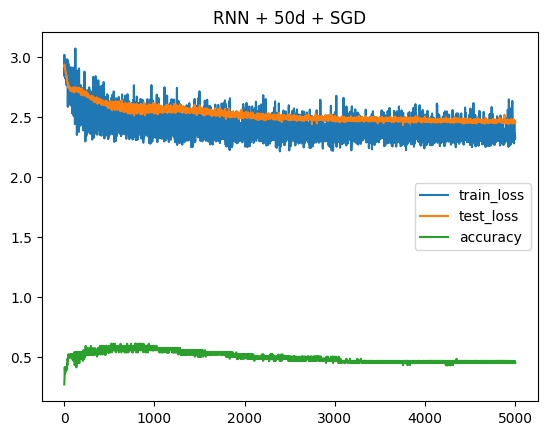

In [21]:
x = np.arange(5000)
plt.plot(x,train_loss, label = 'train_loss')
plt.plot(x,test_loss, label = 'test_loss')
plt.plot(x,accuracy, label = 'accuracy')
plt.legend()
plt.title("RNN + 50d + SGD")

In [24]:
# GD 경사하강법

Rnn = RNN(0.005, 1, 50, d50)
correct = 0
train_loss =[] 
test_loss = []
accuracy = []
for j in range(1000):
    for i in range(132):
        loss = Rnn.loss(train_for_vec[i], train_label[i][:,np.newaxis])
        Rnn.GD()
        if i==131:
            train_loss.append(loss)
    for i in range(56):
        out = Rnn.forward(test_for_vec[i], test_label[i][:,np.newaxis])
        if np.argmax(out) == np.argmax(test_label[i]):
            correct+=1
        if i == 55:
            loss = Rnn.loss(test_for_vec[i], test_label[i][:,np.newaxis])
            test_loss.append(loss)
    print(j+1,"번째 iter :",train_loss[j])
    print("Accuracy :",correct/56)
    accuracy.append(correct/56)
    correct = 0

1 번째 iter : 1.7913430214450758
Accuracy : 0.25
2 번째 iter : 1.715341574152376
Accuracy : 0.3392857142857143
3 번째 iter : 1.6837522872061772
Accuracy : 0.35714285714285715
4 번째 iter : 1.6636296042098428
Accuracy : 0.35714285714285715
5 번째 iter : 1.6490316632235318
Accuracy : 0.44642857142857145
6 번째 iter : 1.637934816185544
Accuracy : 0.4107142857142857
7 번째 iter : 1.6292977761260392
Accuracy : 0.42857142857142855
8 번째 iter : 1.6224686433509257
Accuracy : 0.42857142857142855
9 번째 iter : 1.616997721748179
Accuracy : 0.42857142857142855
10 번째 iter : 1.612556056174723
Accuracy : 0.4107142857142857
11 번째 iter : 1.608892284980434
Accuracy : 0.4107142857142857
12 번째 iter : 1.6058059036573047
Accuracy : 0.4107142857142857
13 번째 iter : 1.6031285102301107
Accuracy : 0.42857142857142855
14 번째 iter : 1.6007100962345444
Accuracy : 0.42857142857142855
15 번째 iter : 1.598409584370719
Accuracy : 0.44642857142857145
16 번째 iter : 1.5960893984741589
Accuracy : 0.4642857142857143
17 번째 iter : 1.5936138370844

138 번째 iter : 1.0883197615275793
Accuracy : 0.5357142857142857
139 번째 iter : 1.0886936743824247
Accuracy : 0.5357142857142857
140 번째 iter : 1.089015729240217
Accuracy : 0.5357142857142857
141 번째 iter : 1.0892833049598705
Accuracy : 0.5357142857142857
142 번째 iter : 1.0894946019711287
Accuracy : 0.5357142857142857
143 번째 iter : 1.0896486823929956
Accuracy : 0.5357142857142857
144 번째 iter : 1.0897454848464314
Accuracy : 0.5357142857142857
145 번째 iter : 1.0897858136049465
Accuracy : 0.5357142857142857
146 번째 iter : 1.0897713038531698
Accuracy : 0.5357142857142857
147 번째 iter : 1.0897043673607505
Accuracy : 0.5357142857142857
148 번째 iter : 1.0895881256123081
Accuracy : 0.5357142857142857
149 번째 iter : 1.0894263398910535
Accuracy : 0.5357142857142857
150 번째 iter : 1.0892233493652175
Accuracy : 0.5357142857142857
151 번째 iter : 1.0889840282776702
Accuracy : 0.5357142857142857
152 번째 iter : 1.0887137715415116
Accuracy : 0.5357142857142857
153 번째 iter : 1.0884185144379963
Accuracy : 0.5357142857

277 번째 iter : 1.165663073187795
Accuracy : 0.5892857142857143
278 번째 iter : 1.1642781616186193
Accuracy : 0.5892857142857143
279 번째 iter : 1.1628628767542386
Accuracy : 0.5892857142857143
280 번째 iter : 1.1614194760093612
Accuracy : 0.5892857142857143
281 번째 iter : 1.1599502755973354
Accuracy : 0.5892857142857143
282 번째 iter : 1.158457634277542
Accuracy : 0.5892857142857143
283 번째 iter : 1.156943936388417
Accuracy : 0.5892857142857143
284 번째 iter : 1.155411574432129
Accuracy : 0.5892857142857143
285 번째 iter : 1.1538629315000741
Accuracy : 0.5892857142857143
286 번째 iter : 1.152300363846198
Accuracy : 0.5892857142857143
287 번째 iter : 1.1507261839270677
Accuracy : 0.5892857142857143
288 번째 iter : 1.1491426442328307
Accuracy : 0.5892857142857143
289 번째 iter : 1.1475519222308206
Accuracy : 0.5892857142857143
290 번째 iter : 1.1459561067326614
Accuracy : 0.5892857142857143
291 번째 iter : 1.1443571859752792
Accuracy : 0.5892857142857143
292 번째 iter : 1.1427570376752099
Accuracy : 0.58928571428571

410 번째 iter : 1.0333751264975046
Accuracy : 0.6071428571428571
411 번째 iter : 1.0329031907567854
Accuracy : 0.6071428571428571
412 번째 iter : 1.0324292639225086
Accuracy : 0.6071428571428571
413 번째 iter : 1.0319534909807173
Accuracy : 0.625
414 번째 iter : 1.031476005052106
Accuracy : 0.625
415 번째 iter : 1.030996928585381
Accuracy : 0.625
416 번째 iter : 1.0305163745224182
Accuracy : 0.625
417 번째 iter : 1.0300344474197256
Accuracy : 0.625
418 번째 iter : 1.0295512445167887
Accuracy : 0.625
419 번째 iter : 1.0290668567464023
Accuracy : 0.625
420 번째 iter : 1.0285813696853587
Accuracy : 0.625
421 번째 iter : 1.028094864446287
Accuracy : 0.625
422 번째 iter : 1.0276074185129662
Accuracy : 0.625
423 번째 iter : 1.0271191065224476
Accuracy : 0.625
424 번째 iter : 1.0266300009977378
Accuracy : 0.625
425 번째 iter : 1.0261401730349606
Accuracy : 0.625
426 번째 iter : 1.0256496929485264
Accuracy : 0.625
427 번째 iter : 1.0251586308774685
Accuracy : 0.625
428 번째 iter : 1.024667057355141
Accuracy : 0.625
429 번째 iter : 1

550 번째 iter : 0.9718783064036218
Accuracy : 0.6428571428571429
551 번째 iter : 0.9705037926529493
Accuracy : 0.6428571428571429
552 번째 iter : 0.9729619262413949
Accuracy : 0.6428571428571429
553 번째 iter : 0.973424446338814
Accuracy : 0.6428571428571429
554 번째 iter : 0.9696356843617839
Accuracy : 0.6428571428571429
555 번째 iter : 0.9702900183338661
Accuracy : 0.6428571428571429
556 번째 iter : 0.9692042385521131
Accuracy : 0.6428571428571429
557 번째 iter : 0.9712466064601055
Accuracy : 0.6428571428571429
558 번째 iter : 0.9720002460847184
Accuracy : 0.6428571428571429
559 번째 iter : 0.968532193240305
Accuracy : 0.6428571428571429
560 번째 iter : 0.9678897470277898
Accuracy : 0.6428571428571429
561 번째 iter : 0.9666327020204727
Accuracy : 0.6428571428571429
562 번째 iter : 0.9701327175655804
Accuracy : 0.6607142857142857
563 번째 iter : 0.9713899772727974
Accuracy : 0.6428571428571429
564 번째 iter : 0.969348647384266
Accuracy : 0.6428571428571429
565 번째 iter : 0.9663047728869428
Accuracy : 0.642857142857

689 번째 iter : 0.9426779524173873
Accuracy : 0.6428571428571429
690 번째 iter : 0.9434942186746527
Accuracy : 0.625
691 번째 iter : 0.9435944016791741
Accuracy : 0.6428571428571429
692 번째 iter : 0.9456656167739093
Accuracy : 0.6785714285714286
693 번째 iter : 0.9456922344868233
Accuracy : 0.6785714285714286
694 번째 iter : 0.9449449431463253
Accuracy : 0.6785714285714286
695 번째 iter : 0.9431444811254247
Accuracy : 0.6785714285714286
696 번째 iter : 0.9393117286420657
Accuracy : 0.6428571428571429
697 번째 iter : 0.9427927318389494
Accuracy : 0.6428571428571429
698 번째 iter : 0.9445324233943798
Accuracy : 0.6785714285714286
699 번째 iter : 0.9443095830803178
Accuracy : 0.6785714285714286
700 번째 iter : 0.9445161650316957
Accuracy : 0.6785714285714286
701 번째 iter : 0.9441941392955114
Accuracy : 0.6785714285714286
702 번째 iter : 0.9437391110595504
Accuracy : 0.6785714285714286
703 번째 iter : 0.9430365345633256
Accuracy : 0.6785714285714286
704 번째 iter : 0.9414736969622681
Accuracy : 0.6607142857142857
705 번

835 번째 iter : 0.9309452750846248
Accuracy : 0.625
836 번째 iter : 0.9308487061735929
Accuracy : 0.625
837 번째 iter : 0.9307515794660117
Accuracy : 0.625
838 번째 iter : 0.9306538533993476
Accuracy : 0.625
839 번째 iter : 0.9305554870167013
Accuracy : 0.625
840 번째 iter : 0.9304564399454852
Accuracy : 0.625
841 번째 iter : 0.9303566723758321
Accuracy : 0.625
842 번째 iter : 0.9302561450385571
Accuracy : 0.625
843 번째 iter : 0.930154819182452
Accuracy : 0.625
844 번째 iter : 0.9300526565507199
Accuracy : 0.625
845 번째 iter : 0.9299496193562913
Accuracy : 0.625
846 번째 iter : 0.9298456702558101
Accuracy : 0.625
847 번째 iter : 0.9297407723220624
Accuracy : 0.625
848 번째 iter : 0.9296348890146113
Accuracy : 0.625
849 번째 iter : 0.9295279841484997
Accuracy : 0.625
850 번째 iter : 0.9294200218608423
Accuracy : 0.625
851 번째 iter : 0.929310966575277
Accuracy : 0.625
852 번째 iter : 0.9292007829642774
Accuracy : 0.625
853 번째 iter : 0.9290894359094803
Accuracy : 0.625
854 번째 iter : 0.9289768904603115
Accuracy : 0.625
85

Text(0.5, 1.0, 'RNN + 50d + GD')

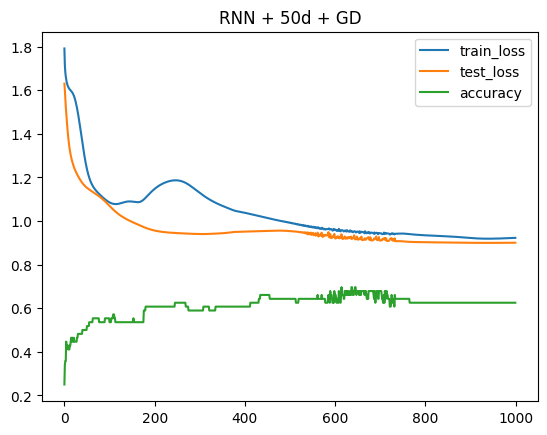

In [25]:
x = np.arange(1000)
plt.plot(x,train_loss, label = 'train_loss')
plt.plot(x,test_loss, label = 'test_loss')
plt.plot(x,accuracy, label = 'accuracy')
plt.legend()
plt.title("RNN + 50d + GD")

In [26]:
class LSTM():
    def __init__(self, learning_rate, batch_size, Bow_len, vector, Drop = 0):
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.Bow_len = Bow_len
        self.Drop = Drop
        self.vector = vector
        self.prev_a_t1, self.prev_a_t2, self.prev_c_t1, self.prev_c_t2 = np.random.randn(5, self.batch_size)*np.sqrt(1/5), np.random.randn(5, self.batch_size)*np.sqrt(1/5),np.random.randn(5, self.batch_size)*np.sqrt(1/5), np.random.randn(5, self.batch_size)*np.sqrt(1/5)
        # parameters 초기화
        self.W_f1 = np.random.randn(5, Bow_len + 5)*np.sqrt(1/5)
        self.b_f1 = np.random.randn(5, 1)*np.sqrt(1/5)
        self.W_f2 = np.random.randn(5, 5 + 5)*np.sqrt(1/5)
        self.b_f2 = np.random.randn(5, 1)*np.sqrt(1/5)
        self.W_c1 = np.random.randn(5, Bow_len + 5)*np.sqrt(1/5)
        self.b_c1 = np.random.randn(5, 1)*np.sqrt(1/5)
        self.W_c2 = np.random.randn(5, 5 + 5)*np.sqrt(1/5)
        self.b_c2 = np.random.randn(5, 1)*np.sqrt(1/5)
        self.W_i1 = np.random.randn(5, Bow_len + 5)*np.sqrt(1/5)
        self.b_i1 = np.random.randn(5, 1)*np.sqrt(1/5)
        self.W_i2 = np.random.randn(5, 5 + 5)*np.sqrt(1/5)
        self.b_i2 = np.random.randn(5, 1)*np.sqrt(1/5)
        self.W_o1 = np.random.randn(5, Bow_len + 5)*np.sqrt(1/5)
        self.b_o1 = np.random.randn(5, 1)*np.sqrt(1/5)
        self.W_o2 = np.random.randn(5, 5 + 5)*np.sqrt(1/5)
        self.b_o2 = np.random.randn(5, 1)*np.sqrt(1/5)
        self.W_y = np.random.randn(5, 5)*np.sqrt(1/5)
        self.b_y = np.random.randn(5, 1)*np.sqrt(1/5)
        self.grad = [self.W_y, self.b_y, self.W_f2, self.W_i2, self.W_o2, self.W_c2, self.W_f1,self.W_i1,self.W_o1,self.W_c1,self.b_f2,self.b_i2,self.b_o2,self.b_c2,self.b_f1,self.b_i1,self.b_o1,self.b_c1]
        
        # tanh, softmax 정의
        self.tanh = tanh()
        self.softmax = Softmax_CE_loss()
        self.sigmoid = sigmoid()
        self.information = None
        self.y_t = None
        
        # Adam parameter
        self.first_moment = [0]*18
        self.second_moment = [0]*18
        self.first_unbias = [0]*18
        self.second_unbias = [0]*18
        self.count = 1
        
        
    def forward(self, x, y):
        self.information = []
        for i in range(len(x)):
            concat_prev_a_t1_x = np.concatenate((self.prev_a_t1, d50[2][x[i].lower()][:,np.newaxis]), axis = 0)
            f_t1 = self.sigmoid.forward(np.dot(self.W_f1, concat_prev_a_t1_x) + self.b_f1)
            cc_t1 = self.tanh.forward(np.dot(self.W_c1, concat_prev_a_t1_x) + self.b_c1)
            i_t1 = self.sigmoid.forward(np.dot(self.W_i1, concat_prev_a_t1_x) + self.b_i1)
            o_t1 = self.sigmoid.forward(np.dot(self.W_o1,concat_prev_a_t1_x) + self.b_o1)
            
            c_t1 = f_t1*self.prev_c_t1 + i_t1*cc_t1
            a_t1 = o_t1*self.tanh.forward(c_t1)
            
            P_drop = np.random.choice([0, 1], p=[1 - self.Drop, self.Drop])
            if P_drop == 0:
                concat_prev_a_t2_a_t1 = np.concatenate((self.prev_a_t2, a_t1), axis = 0)
            else:
                concat_prev_a_t2_a_t1 = np.concatenate((self.prev_a_t2, np.zeros(a_t1.shape)), axis = 0)
            f_t2 = self.sigmoid.forward(np.dot(self.W_f2, concat_prev_a_t2_a_t1) + self.b_f2)
            cc_t2 = self.tanh.forward(np.dot(self.W_c2, concat_prev_a_t2_a_t1) + self.b_c2)
            i_t2 = self.sigmoid.forward(np.dot(self.W_i2, concat_prev_a_t2_a_t1) + self.b_i2)
            o_t2 = self.sigmoid.forward(np.dot(self.W_o2,concat_prev_a_t2_a_t1) + self.b_o2)
            
            c_t2 = f_t2*self.prev_c_t2 + i_t2*cc_t2
            a_t2 = o_t2*self.tanh.forward(c_t2)
            
            # backpropagation에서 사용할 정보 저장 (매 layer의 Drop 여부, x_t, prev_a_t1, a_t1, prev_a_t2, a_t2, prev_c_t1, c_t1, prev_c_t2, c_t2, o_t1, o_t2, i_t1, i_t2, cc_t1, cc_t2, f_t1, f_t2)
            self.information.append((P_drop, d50[2][x[i].lower()][:,np.newaxis], self.prev_a_t1, a_t1, self.prev_a_t2, a_t2, self.prev_c_t1, c_t1, self.prev_c_t2, c_t2, o_t1, o_t2, i_t1, i_t2, cc_t1, cc_t2, f_t1, f_t2))
            self.prev_a_t1, self.prev_a_t2, self.prev_c_t1, self.prev_c_t2 = a_t1, a_t2, c_t1, c_t2
            
        out = np.dot(self.W_y, a_t2) + self.b_y
        return out
    
    def loss(self, x, y):
        out = self.forward(x,y)
        self.y_t = self.softmax.forward(out, y)
        return self.y_t
            
    def backward(self):
        output_gradient = self.softmax.backward()
        dW_f1, dW_f2, dW_cc1, dW_cc2, dW_i1, dW_i2, dW_o1, dW_o2, db_f1, db_f2, db_cc1, db_cc2, db_i1, db_i2, db_o1, db_o2, dW_y, db_y \
        = np.zeros((5, self.Bow_len+5)), np.zeros((5, 5+5)), np.zeros((5, self.Bow_len+5)), np.zeros((5, 5+5)), np.zeros((5, self.Bow_len+5)), np.zeros((5, 5+5)), np.zeros((5, self.Bow_len+5)), np.zeros((5, 5+5)) \
        , np.zeros((5,1)), np.zeros((5,1)), np.zeros((5,1)), np.zeros((5,1)), np.zeros((5,1)), np.zeros((5,1)), np.zeros((5,1)), np.zeros((5,1)), np.zeros((5,5)), np.zeros((5,1))
        # y_t = softmax( W_y * a_t + b_y ) 의 backpropagation
        dW_y += np.dot(output_gradient, self.information[-1][5].T)
        db_y += np.sum(output_gradient, keepdims = True, axis = -1)
        
        output_gradient = np.dot(self.W_y.T, output_gradient)
        # o_t2 * da_t2 * (1 - tanh(c_t2)**2)
        dc_t2 = self.information[-1][11] * output_gradient * self.tanh.backward(self.information[-1][9]) 
        # dc_t1 의 update를 도와주기 위한 변수
        cnt = 0
            
        for i in range(len(self.information)-1, -1, -1):
            # da_t2 * tanh(c_t2) * (o_t2 * (1 - o_t2))
            do_t2 = output_gradient * self.tanh.forward(self.information[i][9]) * self.sigmoid.backward(self.information[i][11])
            # (dc_t2 * i_t2) * (1 - tanh(cc_t2)**2)
            dcc_t2 = dc_t2 * self.information[i][13] * self.tanh.backward(self.information[i][15])
            # (dc_t2 * cc_t2) * (i_t2 * (1 - i_t2))
            di_t2 = dc_t2 * self.information[i][15] * self.sigmoid.backward(self.information[i][13])
            # (dc_t2 * prev_c_t2) * (f_t2 * (1 - f_t2))
            df_t2 = dc_t2 * self.information[i][8] * self.sigmoid.backward(self.information[i][17])

            concat_prev_a_t2_a_t1 = np.concatenate((self.information[i][4], self.information[i][3]), axis = 0)

            dW_f2 += np.dot(df_t2, concat_prev_a_t2_a_t1.T)
            dW_i2 += np.dot(di_t2, concat_prev_a_t2_a_t1.T)
            dW_o2 += np.dot(do_t2, concat_prev_a_t2_a_t1.T)
            dW_cc2 += np.dot(dcc_t2, concat_prev_a_t2_a_t1.T)

            db_f2 += np.sum(df_t2, keepdims = True, axis = -1)
            db_i2 += np.sum(di_t2, keepdims = True, axis = -1)
            db_o2 += np.sum(do_t2, keepdims = True, axis = -1)
            db_cc2 += np.sum(dcc_t2, keepdims = True, axis = -1)

            # gradient를 구한 이전 layer에서의 a의 gradient를 구하기 (prev_a_t2)
            output_gradient = (np.dot(self.W_f2.T , df_t2) + np.dot(self.W_i2.T , di_t2) + np.dot(self.W_o2.T , do_t2) + np.dot(self.W_c2.T , dcc_t2))[:5 , :]
            # (prev_c_t2) 구하기
            dc_t2 = dc_t2 * self.information[i][17]
            # 1 layer의 a_t1의 gradient 구하기
            da_t1 = (np.dot(self.W_f2.T , df_t2) + np.dot(self.W_i2.T , di_t2) + np.dot(self.W_o2.T , do_t2) + np.dot(self.W_c2.T , dcc_t2))[5: , :]
            
            if cnt == 0 :
                # o_t1 * da_t1 * (1 - tanh(c_t1)**2)
                dc_t1 = self.information[-1][10] * da_t1 * self.tanh.backward(self.information[-1][7])
            else:
                dc_t1 = dc_t1 * self.information[i][16]
            cnt+=1

            # da_t1 * tanh(c_t1) * (o_t1 * (1 - o_t1))
            do_t1 = da_t1 * self.tanh.forward(self.information[i][7]) * self.sigmoid.backward(self.information[i][10])
            # (dc_t1 * i_t1) * (1 - tanh(cc_t1)**2)
            dcc_t1 = dc_t1 * self.information[i][12] * self.tanh.backward(self.information[i][14])
            # (dc_t1 * cc_t1) * (i_t1 * (1 - i_t1))
            di_t1 = dc_t1 * self.information[i][14] * self.sigmoid.backward(self.information[i][12])
            # (dc_t1 * prev_c_t1) * (f_t1 * (1 - f_t1))
            df_t1 = dc_t1 * self.information[i][6] * self.sigmoid.backward(self.information[i][16])

            concat_prev_a_t1_x = np.concatenate((self.information[i][2], self.information[i][1]), axis = 0)

            dW_f1 += np.dot(df_t1, concat_prev_a_t1_x.T)
            dW_i1 += np.dot(di_t1, concat_prev_a_t1_x.T)
            dW_o1 += np.dot(do_t1, concat_prev_a_t1_x.T)
            dW_cc1 += np.dot(dcc_t1, concat_prev_a_t1_x.T)

            db_f1 += np.sum(df_t1, keepdims = True, axis = -1)
            db_i1 += np.sum(di_t1, keepdims = True, axis = -1)
            db_o1 += np.sum(do_t1, keepdims = True, axis = -1)
            db_cc1 += np.sum(dcc_t1, keepdims = True, axis = -1)

        # dW_hh, dW_xh, dW_hy, db_h, db_y 순서로 tuple로 return (SGD나 ADAM으로 이어짐)
        return (dW_y, db_y, dW_f2, dW_i2, dW_o2, dW_cc2, dW_f1, dW_i1, dW_o1, dW_cc1, db_f2, db_i2, db_o2, db_cc2, db_f1, db_i1, db_o1, db_cc1)
        
    def GD(self):
        # GD 함수를 사용하면 backward를 한 결과 gradient를 빼준다.
        gradient = self.backward()
        self.W_y -= (self.learning_rate * gradient[0] / self.batch_size)
        self.b_y -= (self.learning_rate * gradient[1] / self.batch_size)
        self.W_f2 -= (self.learning_rate * gradient[2] / self.batch_size)
        self.W_i2 -= (self.learning_rate * gradient[3] / self.batch_size)
        self.W_o2 -= (self.learning_rate * gradient[4] / self.batch_size)
        self.W_c2 -= (self.learning_rate * gradient[5] / self.batch_size)
        self.W_f1 -= (self.learning_rate * gradient[6] / self.batch_size)
        self.W_i1 -= (self.learning_rate * gradient[7] / self.batch_size)
        self.W_o1 -= (self.learning_rate * gradient[8] / self.batch_size)
        self.W_c1 -= (self.learning_rate * gradient[9] / self.batch_size)
        self.b_f2 -= (self.learning_rate * gradient[10] / self.batch_size)
        self.b_i2 -= (self.learning_rate * gradient[11] / self.batch_size)
        self.b_o2 -= (self.learning_rate * gradient[12] / self.batch_size)
        self.b_c2 -= (self.learning_rate * gradient[13] / self.batch_size)
        self.b_f1 -= (self.learning_rate * gradient[14] / self.batch_size)
        self.b_i1 -= (self.learning_rate * gradient[15] / self.batch_size)
        self.b_o1 -= (self.learning_rate * gradient[16] / self.batch_size)
        self.b_c1 -= (self.learning_rate * gradient[17] / self.batch_size)
        
    def SGD(self,x,y):
        vec = np.zeros((10, self.batch_size, len(self.vector[2]['his'])))
        for i in range(self.batch_size):
            for j in range(len(x[i])):
                vec[j,i] = self.vector[2][x[i][j].lower()]
        self.information = []
        for i in range(len(x)):
            concat_prev_a_t1_x = np.concatenate((self.prev_a_t1, vec[i].T), axis = 0)
            f_t1 = self.sigmoid.forward(np.dot(self.W_f1, concat_prev_a_t1_x) + self.b_f1)
            cc_t1 = self.tanh.forward(np.dot(self.W_c1, concat_prev_a_t1_x) + self.b_c1)
            i_t1 = self.sigmoid.forward(np.dot(self.W_i1, concat_prev_a_t1_x) + self.b_i1)
            o_t1 = self.sigmoid.forward(np.dot(self.W_o1,concat_prev_a_t1_x) + self.b_o1)
            
            c_t1 = f_t1*self.prev_c_t1 + i_t1*cc_t1
            a_t1 = o_t1*self.tanh.forward(c_t1)
            
            P_drop = np.random.choice([0, 1], p=[1 - self.Drop, self.Drop])
            if P_drop == 0:
                concat_prev_a_t2_a_t1 = np.concatenate((self.prev_a_t2, a_t1), axis = 0)
            else:
                concat_prev_a_t2_a_t1 = np.concatenate((self.prev_a_t2, np.zeros(a_t1.shape)), axis = 0)
            f_t2 = self.sigmoid.forward(np.dot(self.W_f2, concat_prev_a_t2_a_t1) + self.b_f2)
            cc_t2 = self.tanh.forward(np.dot(self.W_c2, concat_prev_a_t2_a_t1) + self.b_c2)
            i_t2 = self.sigmoid.forward(np.dot(self.W_i2, concat_prev_a_t2_a_t1) + self.b_i2)
            o_t2 = self.sigmoid.forward(np.dot(self.W_o2,concat_prev_a_t2_a_t1) + self.b_o2)
            
            c_t2 = f_t2*self.prev_c_t2 + i_t2*cc_t2
            a_t2 = o_t2*self.tanh.forward(c_t2)
            
            # backpropagation에서 사용할 정보 저장 (매 layer의 Drop 여부, x_t, prev_a_t1, a_t1, prev_a_t2, a_t2, prev_c_t1, c_t1, prev_c_t2, c_t2, o_t1, o_t2, i_t1, i_t2, cc_t1, cc_t2, f_t1, f_t2)
            self.information.append((P_drop, vec[i].T, self.prev_a_t1, a_t1, self.prev_a_t2, a_t2, self.prev_c_t1, c_t1, self.prev_c_t2, c_t2, o_t1, o_t2, i_t1, i_t2, cc_t1, cc_t2, f_t1, f_t2))
            self.prev_a_t1, self.prev_a_t2, self.prev_c_t1, self.prev_c_t2 = a_t1, a_t2, c_t1, c_t2
            
        out = np.dot(self.W_y, a_t2) + self.b_y
        self.y_t = self.softmax.forward(out,y.T)
        self.GD()
        return self.y_t
    
    def SGD_forward_only(self,x,y):
        vec = np.zeros((10, self.batch_size, len(self.vector[2]['his'])))
        for i in range(self.batch_size):
            for j in range(len(x[i])):
                vec[j,i] = self.vector[2][x[i][j].lower()]
        for i in range(len(x)):
            concat_prev_a_t1_x = np.concatenate((self.prev_a_t1, vec[i].T), axis = 0)
            f_t1 = self.sigmoid.forward(np.dot(self.W_f1, concat_prev_a_t1_x) + self.b_f1)
            cc_t1 = self.tanh.forward(np.dot(self.W_c1, concat_prev_a_t1_x) + self.b_c1)
            i_t1 = self.sigmoid.forward(np.dot(self.W_i1, concat_prev_a_t1_x) + self.b_i1)
            o_t1 = self.sigmoid.forward(np.dot(self.W_o1,concat_prev_a_t1_x) + self.b_o1)
            
            c_t1 = f_t1*self.prev_c_t1 + i_t1*cc_t1
            a_t1 = o_t1*self.tanh.forward(c_t1)
            
            P_drop = np.random.choice([0, 1], p=[1 - self.Drop, self.Drop])
            if P_drop == 0:
                concat_prev_a_t2_a_t1 = np.concatenate((self.prev_a_t2, a_t1), axis = 0)
            else:
                concat_prev_a_t2_a_t1 = np.concatenate((self.prev_a_t2, np.zeros(a_t1.shape)), axis = 0)
            f_t2 = self.sigmoid.forward(np.dot(self.W_f2, concat_prev_a_t2_a_t1) + self.b_f2)
            cc_t2 = self.tanh.forward(np.dot(self.W_c2, concat_prev_a_t2_a_t1) + self.b_c2)
            i_t2 = self.sigmoid.forward(np.dot(self.W_i2, concat_prev_a_t2_a_t1) + self.b_i2)
            o_t2 = self.sigmoid.forward(np.dot(self.W_o2,concat_prev_a_t2_a_t1) + self.b_o2)
            
            c_t2 = f_t2*self.prev_c_t2 + i_t2*cc_t2
            a_t2 = o_t2*self.tanh.forward(c_t2)
            
            self.prev_a_t1, self.prev_a_t2, self.prev_c_t1, self.prev_c_t2 = a_t1, a_t2, c_t1, c_t2
            
        out = np.dot(self.W_y, a_t2) + self.b_y
        return out
        
    def Adam(self, beta1 = 0.9, beta2 = 0.999):
        gradient = self.backward()
        for i in range(len(gradient)):
            self.first_moment[i] = beta1 * self.first_moment[i] + (1-beta1)*gradient[i]
            self.second_moment[i] = beta2 * self.second_moment[i] + (1-beta2)*gradient[i]*gradient[i]
            self.first_unbias[i] = self.first_moment[i] / (1-beta1**self.count)
            self.second_unbias[i] = self.second_moment[i] / (1-beta2**self.count)
            self.grad[i] -= (self.learning_rate * self.first_unbias[i]/(np.sqrt(self.second_unbias[i]+1e07)))
        self.count+=1

In [27]:
# Adam optimizer

lstm = LSTM(0.01, 1, 50, d50)
correct = 0
train_loss =[] 
test_loss = []
accuracy = []
for j in range(1000):
    for i in range(132):
        loss = lstm.loss(train_for_vec[i], train_label[i][:,np.newaxis])
        lstm.Adam()
        if i==131:
            train_loss.append(loss)
    for i in range(56):
        out = lstm.forward(test_for_vec[i], test_label[i][:,np.newaxis])
        if np.argmax(out) == np.argmax(test_label[i]):
            correct+=1
        if i == 55:
            loss = Rnn.loss(test_for_vec[i], test_label[i][:,np.newaxis])
            test_loss.append(loss)
    print(j+1,"번째 iter :",train_loss[j])
    print("Accuracy :",correct/56)
    accuracy.append(correct/56)
    correct = 0

1 번째 iter : 1.483595833352059
Accuracy : 0.125
2 번째 iter : 1.483849897376553
Accuracy : 0.125
3 번째 iter : 1.4841039163136
Accuracy : 0.125
4 번째 iter : 1.484357888543832
Accuracy : 0.125
5 번째 iter : 1.4846118124459131
Accuracy : 0.125
6 번째 iter : 1.484865686398165
Accuracy : 0.125
7 번째 iter : 1.4851195087786127
Accuracy : 0.125
8 번째 iter : 1.4853732779650302
Accuracy : 0.125
9 번째 iter : 1.4856269923349894
Accuracy : 0.125
10 번째 iter : 1.4858806502659077
Accuracy : 0.125
11 번째 iter : 1.4861342501350943
Accuracy : 0.125
12 번째 iter : 1.4863877903197973
Accuracy : 0.125
13 번째 iter : 1.486641269197252
Accuracy : 0.125
14 번째 iter : 1.4868946851447276
Accuracy : 0.125
15 번째 iter : 1.4871480365395757
Accuracy : 0.125
16 번째 iter : 1.487401321759278
Accuracy : 0.125
17 번째 iter : 1.4876545391814944
Accuracy : 0.125
18 번째 iter : 1.4879076871841062
Accuracy : 0.125
19 번째 iter : 1.488160764145271
Accuracy : 0.125
20 번째 iter : 1.488413768443466
Accuracy : 0.125
21 번째 iter : 1.4886666984575372
Accuracy

168 번째 iter : 1.524199706104244
Accuracy : 0.125
169 번째 iter : 1.5244249374342898
Accuracy : 0.125
170 번째 iter : 1.5246498826369952
Accuracy : 0.125
171 번째 iter : 1.5248745406392639
Accuracy : 0.125
172 번째 iter : 1.5250989103741868
Accuracy : 0.125
173 번째 iter : 1.5253229907810606
Accuracy : 0.125
174 번째 iter : 1.5255467808054108
Accuracy : 0.125
175 번째 iter : 1.5257702793990073
Accuracy : 0.125
176 번째 iter : 1.525993485519882
Accuracy : 0.125
177 번째 iter : 1.5262163981323482
Accuracy : 0.125
178 번째 iter : 1.5264390162070178
Accuracy : 0.125
179 번째 iter : 1.5266613387208199
Accuracy : 0.125
180 번째 iter : 1.5268833646570166
Accuracy : 0.125
181 번째 iter : 1.5271050930052181
Accuracy : 0.125
182 번째 iter : 1.527326522761403
Accuracy : 0.125
183 번째 iter : 1.52754765292793
Accuracy : 0.125
184 번째 iter : 1.5277684825135573
Accuracy : 0.125
185 번째 iter : 1.527989010533454
Accuracy : 0.125
186 번째 iter : 1.5282092360092188
Accuracy : 0.125
187 번째 iter : 1.5284291579688922
Accuracy : 0.125
188 번째

333 번째 iter : 1.5568970546204766
Accuracy : 0.125
334 번째 iter : 1.5570653676096042
Accuracy : 0.125
335 번째 iter : 1.5572333057733048
Accuracy : 0.125
336 번째 iter : 1.5574008690910313
Accuracy : 0.125
337 번째 iter : 1.5575680575476145
Accuracy : 0.125
338 번째 iter : 1.5577348711332357
Accuracy : 0.125
339 번째 iter : 1.5579013098434091
Accuracy : 0.125
340 번째 iter : 1.5580673736789532
Accuracy : 0.125
341 번째 iter : 1.5582330626459737
Accuracy : 0.125
342 번째 iter : 1.558398376755837
Accuracy : 0.125
343 번째 iter : 1.558563316025145
Accuracy : 0.125
344 번째 iter : 1.5587278804757179
Accuracy : 0.125
345 번째 iter : 1.5588920701345643
Accuracy : 0.125
346 번째 iter : 1.5590558850338634
Accuracy : 0.125
347 번째 iter : 1.559219325210937
Accuracy : 0.125
348 번째 iter : 1.5593823907082287
Accuracy : 0.125
349 번째 iter : 1.5595450815732779
Accuracy : 0.125
350 번째 iter : 1.559707397858699
Accuracy : 0.125
351 번째 iter : 1.559869339622154
Accuracy : 0.125
352 번째 iter : 1.5600309069263312
Accuracy : 0.125
353 번

498 번째 iter : 1.579718897935245
Accuracy : 0.125
499 번째 iter : 1.5798283091174348
Accuracy : 0.125
500 번째 iter : 1.579937396725169
Accuracy : 0.125
501 번째 iter : 1.5800461612922343
Accuracy : 0.125
502 번째 iter : 1.580154603353833
Accuracy : 0.125
503 번째 iter : 1.5802627234465685
Accuracy : 0.125
504 번째 iter : 1.5803705221084228
Accuracy : 0.125
505 번째 iter : 1.5804779998787368
Accuracy : 0.125
506 번째 iter : 1.5805851572981902
Accuracy : 0.125
507 번째 iter : 1.580691994908784
Accuracy : 0.125
508 번째 iter : 1.5807985132538198
Accuracy : 0.125
509 번째 iter : 1.5809047128778797
Accuracy : 0.125
510 번째 iter : 1.58101059432681
Accuracy : 0.125
511 번째 iter : 1.5811161581476985
Accuracy : 0.125
512 번째 iter : 1.5812214048888575
Accuracy : 0.125
513 번째 iter : 1.5813263350998041
Accuracy : 0.125
514 번째 iter : 1.5814309493312422
Accuracy : 0.125
515 번째 iter : 1.5815352481350426
Accuracy : 0.125
516 번째 iter : 1.581639232064227
Accuracy : 0.125
517 번째 iter : 1.581742901672944
Accuracy : 0.125
518 번째 i

663 번째 iter : 1.5938117436804138
Accuracy : 0.125
664 번째 iter : 1.593875527390278
Accuracy : 0.125
665 번째 iter : 1.5939390829389293
Accuracy : 0.125
666 번째 iter : 1.5940024108927806
Accuracy : 0.125
667 번째 iter : 1.5940655118175993
Accuracy : 0.125
668 번째 iter : 1.594128386278504
Accuracy : 0.125
669 번째 iter : 1.594191034839957
Accuracy : 0.125
670 번째 iter : 1.59425345806576
Accuracy : 0.125
671 번째 iter : 1.594315656519045
Accuracy : 0.125
672 번째 iter : 1.5943776307622735
Accuracy : 0.125
673 번째 iter : 1.594439381357226
Accuracy : 0.125
674 번째 iter : 1.5945009088649995
Accuracy : 0.125
675 번째 iter : 1.5945622138460027
Accuracy : 0.125
676 번째 iter : 1.5946232968599474
Accuracy : 0.125
677 번째 iter : 1.5946841584658464
Accuracy : 0.125
678 번째 iter : 1.5947447992220063
Accuracy : 0.125
679 번째 iter : 1.5948052196860223
Accuracy : 0.125
680 번째 iter : 1.5948654204147747
Accuracy : 0.125
681 번째 iter : 1.5949254019644212
Accuracy : 0.125
682 번째 iter : 1.5949851648903954
Accuracy : 0.125
683 번째 

828 번째 iter : 1.6016420144183035
Accuracy : 0.125
829 번째 iter : 1.6016752182243663
Accuracy : 0.125
830 번째 iter : 1.6017082758483776
Accuracy : 0.125
831 번째 iter : 1.6017411877076337
Accuracy : 0.125
832 번째 iter : 1.6017739542184382
Accuracy : 0.125
833 번째 iter : 1.6018065757961049
Accuracy : 0.125
834 번째 iter : 1.601839052854955
Accuracy : 0.125
835 번째 iter : 1.601871385808321
Accuracy : 0.125
836 번째 iter : 1.6019035750685444
Accuracy : 0.125
837 번째 iter : 1.6019356210469784
Accuracy : 0.125
838 번째 iter : 1.6019675241539866
Accuracy : 0.125
839 번째 iter : 1.6019992847989442
Accuracy : 0.125
840 번째 iter : 1.6020309033902396
Accuracy : 0.125
841 번째 iter : 1.6020623803352747
Accuracy : 0.125
842 번째 iter : 1.6020937160404636
Accuracy : 0.125
843 번째 iter : 1.6021249109112354
Accuracy : 0.125
844 번째 iter : 1.602155965352035
Accuracy : 0.125
845 번째 iter : 1.602186879766322
Accuracy : 0.125
846 번째 iter : 1.6022176545565727
Accuracy : 0.125
847 번째 iter : 1.6022482901242798
Accuracy : 0.125
848 

993 번째 iter : 1.6054208613146612
Accuracy : 0.125
994 번째 iter : 1.6054348894610893
Accuracy : 0.125
995 번째 iter : 1.605448827602106
Accuracy : 0.125
996 번째 iter : 1.6054626760067279
Accuracy : 0.125
997 번째 iter : 1.6054764349432025
Accuracy : 0.125
998 번째 iter : 1.6054901046790075
Accuracy : 0.125
999 번째 iter : 1.6055036854808538
Accuracy : 0.125
1000 번째 iter : 1.6055171776146868
Accuracy : 0.125


Text(0.5, 1.0, 'LSTM + 50d + Adam')

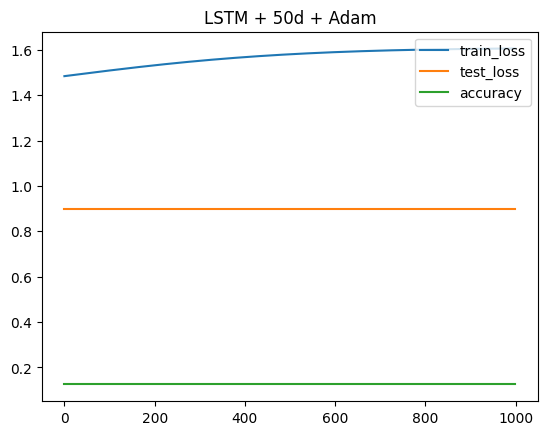

In [28]:
x = np.arange(1000)
plt.plot(x,train_loss, label = 'train_loss')
plt.plot(x,test_loss, label = 'test_loss')
plt.plot(x,accuracy, label = 'accuracy')
plt.legend()
plt.title("LSTM + 50d + Adam")

In [30]:
# SGD 경사하강법

lstm = LSTM(0.05, 4, 50, d50)
correct = 0
train_loss =[] 
test_loss = []
accuracy = []
for j in range(1000):
    c = list(zip(train_for_vec, train_label))
    random.shuffle(c)
    train_for_vec, train_label = zip(*c)
    train_label = np.array(train_label)
    for i in range(132//4):
        loss = lstm.SGD(train_for_vec[i*4:(i+1)*4], train_label[i*4:(i+1)*4])
        if i==132//4-1:
            train_loss.append(loss)
    for i in range(56//4):
        out = lstm.SGD_forward_only(test_for_vec[i*4:(i+1)*4], test_label[i*4:(i+1)*4])
        correct += np.sum(np.argmax(out, axis =0) == np.argmax(test_label[i*4:(i+1)*4],axis=1))
        if i == 56//4-1:
            loss = lstm.SGD(test_for_vec[i*4:(i+1)*4], test_label[i*4:(i+1)*4])
            test_loss.append(loss)
    print(j+1,"번째 iter :",train_loss[j])
    print("Accuracy :",correct/56)
    accuracy.append(correct/56)
    correct = 0

1 번째 iter : 3.0159577980533565
Accuracy : 0.125
2 번째 iter : 2.948167264620834
Accuracy : 0.21428571428571427
3 번째 iter : 3.0070929586409503
Accuracy : 0.32142857142857145
4 번째 iter : 2.981968686264926
Accuracy : 0.3392857142857143
5 번째 iter : 3.0839711455553154
Accuracy : 0.30357142857142855
6 번째 iter : 3.0404581265824753
Accuracy : 0.32142857142857145
7 번째 iter : 2.9854262793268957
Accuracy : 0.32142857142857145
8 번째 iter : 3.0331289349367023
Accuracy : 0.32142857142857145
9 번째 iter : 3.0264825976353453
Accuracy : 0.30357142857142855
10 번째 iter : 2.958560520727322
Accuracy : 0.32142857142857145
11 번째 iter : 3.0237017930002374
Accuracy : 0.32142857142857145
12 번째 iter : 2.966113621288444
Accuracy : 0.32142857142857145
13 번째 iter : 2.9244596332889468
Accuracy : 0.30357142857142855
14 번째 iter : 2.925875337635005
Accuracy : 0.32142857142857145
15 번째 iter : 3.0392539072044817
Accuracy : 0.30357142857142855
16 번째 iter : 2.973802168655615
Accuracy : 0.30357142857142855
17 번째 iter : 2.9758252

136 번째 iter : 2.958106175355566
Accuracy : 0.2857142857142857
137 번째 iter : 2.9057024446324036
Accuracy : 0.2857142857142857
138 번째 iter : 2.920822774519264
Accuracy : 0.30357142857142855
139 번째 iter : 2.932693548471601
Accuracy : 0.2857142857142857
140 번째 iter : 2.901030957992617
Accuracy : 0.2857142857142857
141 번째 iter : 2.933490828204482
Accuracy : 0.30357142857142855
142 번째 iter : 2.987230917689918
Accuracy : 0.26785714285714285
143 번째 iter : 2.938254478510332
Accuracy : 0.26785714285714285
144 번째 iter : 2.993408367346141
Accuracy : 0.2857142857142857
145 번째 iter : 2.970004342154829
Accuracy : 0.30357142857142855
146 번째 iter : 2.958359367651261
Accuracy : 0.30357142857142855
147 번째 iter : 2.9811993876183878
Accuracy : 0.30357142857142855
148 번째 iter : 2.9355879719443387
Accuracy : 0.30357142857142855
149 번째 iter : 2.9319791958461514
Accuracy : 0.2857142857142857
150 번째 iter : 2.912793818826141
Accuracy : 0.2857142857142857
151 번째 iter : 2.9583022699955306
Accuracy : 0.303571428571

273 번째 iter : 2.854434928168459
Accuracy : 0.35714285714285715
274 번째 iter : 2.8776313002941576
Accuracy : 0.32142857142857145
275 번째 iter : 2.928675100714341
Accuracy : 0.3392857142857143
276 번째 iter : 2.9004874816449697
Accuracy : 0.32142857142857145
277 번째 iter : 2.853567704283476
Accuracy : 0.35714285714285715
278 번째 iter : 2.9103170886158236
Accuracy : 0.3392857142857143
279 번째 iter : 2.912056663936661
Accuracy : 0.30357142857142855
280 번째 iter : 2.9208582507358325
Accuracy : 0.32142857142857145
281 번째 iter : 2.951554394127608
Accuracy : 0.4107142857142857
282 번째 iter : 2.9113119570900214
Accuracy : 0.3392857142857143
283 번째 iter : 2.921630677629226
Accuracy : 0.35714285714285715
284 번째 iter : 2.943747199001776
Accuracy : 0.39285714285714285
285 번째 iter : 2.9133545298395034
Accuracy : 0.32142857142857145
286 번째 iter : 2.882775198979326
Accuracy : 0.35714285714285715
287 번째 iter : 2.872817398566592
Accuracy : 0.4107142857142857
288 번째 iter : 2.8765162805653857
Accuracy : 0.35714285

410 번째 iter : 2.8468099441344332
Accuracy : 0.39285714285714285
411 번째 iter : 2.8977718868308053
Accuracy : 0.375
412 번째 iter : 2.779624933026229
Accuracy : 0.375
413 번째 iter : 2.8518006616854716
Accuracy : 0.375
414 번째 iter : 2.8294615592083483
Accuracy : 0.375
415 번째 iter : 2.759377294806476
Accuracy : 0.35714285714285715
416 번째 iter : 2.9993445843744824
Accuracy : 0.375
417 번째 iter : 2.7899949384402936
Accuracy : 0.35714285714285715
418 번째 iter : 2.808595589600799
Accuracy : 0.375
419 번째 iter : 2.786886795519333
Accuracy : 0.35714285714285715
420 번째 iter : 2.8722867543042754
Accuracy : 0.375
421 번째 iter : 3.0069434404549096
Accuracy : 0.375
422 번째 iter : 2.860703716674137
Accuracy : 0.375
423 번째 iter : 2.8890133012894372
Accuracy : 0.39285714285714285
424 번째 iter : 2.8780832895193584
Accuracy : 0.375
425 번째 iter : 2.904461070042573
Accuracy : 0.375
426 번째 iter : 2.731134452694749
Accuracy : 0.375
427 번째 iter : 2.84262428961583
Accuracy : 0.375
428 번째 iter : 2.8069217681487455
Accura

548 번째 iter : 2.829470134093385
Accuracy : 0.42857142857142855
549 번째 iter : 2.7754332176998573
Accuracy : 0.42857142857142855
550 번째 iter : 2.65269829597678
Accuracy : 0.42857142857142855
551 번째 iter : 2.805671173149763
Accuracy : 0.42857142857142855
552 번째 iter : 2.7458847710263563
Accuracy : 0.42857142857142855
553 번째 iter : 2.8817425049730594
Accuracy : 0.42857142857142855
554 번째 iter : 2.7313812390141843
Accuracy : 0.42857142857142855
555 번째 iter : 2.814579580820256
Accuracy : 0.42857142857142855
556 번째 iter : 2.7804139127758636
Accuracy : 0.42857142857142855
557 번째 iter : 2.8042989482029657
Accuracy : 0.42857142857142855
558 번째 iter : 2.799737895277972
Accuracy : 0.42857142857142855
559 번째 iter : 2.8131193316389704
Accuracy : 0.42857142857142855
560 번째 iter : 2.8627774002826003
Accuracy : 0.42857142857142855
561 번째 iter : 2.6387027145046904
Accuracy : 0.42857142857142855
562 번째 iter : 2.6807942722968603
Accuracy : 0.42857142857142855
563 번째 iter : 2.766605029858809
Accuracy : 0.4

680 번째 iter : 2.9406014798109075
Accuracy : 0.44642857142857145
681 번째 iter : 2.727538337606048
Accuracy : 0.42857142857142855
682 번째 iter : 2.61937166064304
Accuracy : 0.4107142857142857
683 번째 iter : 2.7969394303696062
Accuracy : 0.4107142857142857
684 번째 iter : 2.8033265174062256
Accuracy : 0.42857142857142855
685 번째 iter : 2.6342543821901447
Accuracy : 0.42857142857142855
686 번째 iter : 2.7210097164760243
Accuracy : 0.42857142857142855
687 번째 iter : 2.7188499936116752
Accuracy : 0.4107142857142857
688 번째 iter : 2.755061062271271
Accuracy : 0.4107142857142857
689 번째 iter : 2.674828995307468
Accuracy : 0.44642857142857145
690 번째 iter : 2.6428550575704217
Accuracy : 0.4107142857142857
691 번째 iter : 2.6953473209607792
Accuracy : 0.4107142857142857
692 번째 iter : 2.7031400312368126
Accuracy : 0.4107142857142857
693 번째 iter : 2.6237148768407175
Accuracy : 0.4107142857142857
694 번째 iter : 2.648896361027275
Accuracy : 0.4107142857142857
695 번째 iter : 2.670079208614642
Accuracy : 0.4107142857

810 번째 iter : 2.829846814078171
Accuracy : 0.4107142857142857
811 번째 iter : 2.6899715251132346
Accuracy : 0.39285714285714285
812 번째 iter : 2.6765198853421013
Accuracy : 0.4107142857142857
813 번째 iter : 2.6026176705244044
Accuracy : 0.44642857142857145
814 번째 iter : 2.8317344662155195
Accuracy : 0.42857142857142855
815 번째 iter : 2.553957780463622
Accuracy : 0.4107142857142857
816 번째 iter : 2.3173714310557156
Accuracy : 0.39285714285714285
817 번째 iter : 2.639819848671409
Accuracy : 0.4107142857142857
818 번째 iter : 2.6773076853244935
Accuracy : 0.42857142857142855
819 번째 iter : 2.5432471543071293
Accuracy : 0.4107142857142857
820 번째 iter : 2.7871598307764316
Accuracy : 0.4107142857142857
821 번째 iter : 2.5496103011521027
Accuracy : 0.4107142857142857
822 번째 iter : 2.527182054811431
Accuracy : 0.42857142857142855
823 번째 iter : 2.617090346187216
Accuracy : 0.4107142857142857
824 번째 iter : 2.477877896696889
Accuracy : 0.42857142857142855
825 번째 iter : 2.872391145034982
Accuracy : 0.410714285

943 번째 iter : 2.9169157183115226
Accuracy : 0.4642857142857143
944 번째 iter : 2.433167057627697
Accuracy : 0.44642857142857145
945 번째 iter : 2.6068974325318326
Accuracy : 0.44642857142857145
946 번째 iter : 2.741459266787784
Accuracy : 0.44642857142857145
947 번째 iter : 2.60971815544545
Accuracy : 0.44642857142857145
948 번째 iter : 2.3709937703488837
Accuracy : 0.42857142857142855
949 번째 iter : 2.460623468443086
Accuracy : 0.42857142857142855
950 번째 iter : 2.7097921715455437
Accuracy : 0.44642857142857145
951 번째 iter : 2.6637180660367674
Accuracy : 0.44642857142857145
952 번째 iter : 2.5144289451994712
Accuracy : 0.44642857142857145
953 번째 iter : 2.7189953705140066
Accuracy : 0.42857142857142855
954 번째 iter : 2.5967959867098687
Accuracy : 0.42857142857142855
955 번째 iter : 2.5247968269946863
Accuracy : 0.44642857142857145
956 번째 iter : 2.581257436554218
Accuracy : 0.4642857142857143
957 번째 iter : 2.750494458331743
Accuracy : 0.42857142857142855
958 번째 iter : 2.866653455410586
Accuracy : 0.4285

Text(0.5, 1.0, 'LSTM + 50d + SGD')

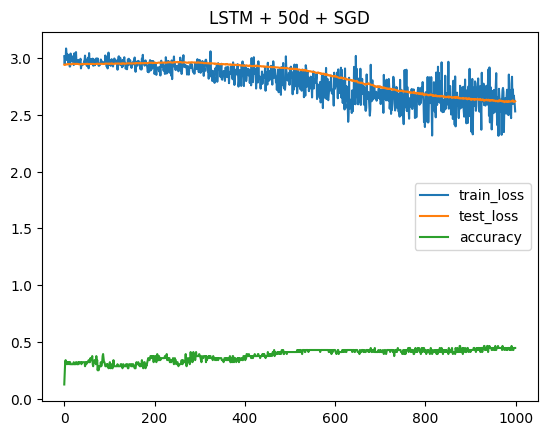

In [31]:
x = np.arange(1000)
plt.plot(x,train_loss, label = 'train_loss')
plt.plot(x,test_loss, label = 'test_loss')
plt.plot(x,accuracy, label = 'accuracy')
plt.legend()
plt.title("LSTM + 50d + SGD")

In [33]:
# GD 경사하강법

lstm = LSTM(0.001, 1, 50, d50)
test_loss = []
train_loss = []
accuracy = []
correct = 0
for j in range(1000):
    for i in range(132):
        loss = lstm.loss(train_for_vec[i], train_label[i][:,np.newaxis])
        lstm.GD()
        if i==131:
            train_loss.append(loss)
    for i in range(56):
        out = lstm.forward(test_for_vec[i], test_label[i][:,np.newaxis])
        if np.argmax(out) == np.argmax(test_label[i]):
            correct+=1
        if i == 55:
            loss = lstm.loss(test_for_vec[i], test_label[i][:,np.newaxis])
            test_loss.append(loss)
    print(j+1,"번째 iter :",train_loss[j])
    print("Accuracy :",correct/56)
    accuracy.append(correct/56)
    correct = 0

1 번째 iter : 0.9153030062664991
Accuracy : 0.125
2 번째 iter : 1.0126455850234095
Accuracy : 0.125
3 번째 iter : 1.0991069622935827
Accuracy : 0.125
4 번째 iter : 1.175223704507389
Accuracy : 0.125
5 번째 iter : 1.2417666392298627
Accuracy : 0.125
6 번째 iter : 1.299616754295476
Accuracy : 0.125
7 번째 iter : 1.3496842711826857
Accuracy : 0.125
8 번째 iter : 1.3928580498710321
Accuracy : 0.125
9 번째 iter : 1.4299757905794381
Accuracy : 0.125
10 번째 iter : 1.4618081513122276
Accuracy : 0.16071428571428573
11 번째 iter : 1.4890519623408238
Accuracy : 0.17857142857142858
12 번째 iter : 1.5123292338670795
Accuracy : 0.19642857142857142
13 번째 iter : 1.5321897219469598
Accuracy : 0.23214285714285715
14 번째 iter : 1.5491155549179716
Accuracy : 0.23214285714285715
15 번째 iter : 1.5635269263315519
Accuracy : 0.2857142857142857
16 번째 iter : 1.5757882040501083
Accuracy : 0.2857142857142857
17 번째 iter : 1.5862140397467703
Accuracy : 0.26785714285714285
18 번째 iter : 1.5950752230354277
Accuracy : 0.25
19 번째 iter : 1.60260

144 번째 iter : 1.6375999256864089
Accuracy : 0.4107142857142857
145 번째 iter : 1.6375656290436853
Accuracy : 0.42857142857142855
146 번째 iter : 1.6375339043251187
Accuracy : 0.42857142857142855
147 번째 iter : 1.6375047554821882
Accuracy : 0.42857142857142855
148 번째 iter : 1.6374781843873412
Accuracy : 0.42857142857142855
149 번째 iter : 1.637454190864751
Accuracy : 0.4107142857142857
150 번째 iter : 1.637432772722876
Accuracy : 0.4107142857142857
151 번째 iter : 1.6374139257887046
Accuracy : 0.4107142857142857
152 번째 iter : 1.6373976439435938
Accuracy : 0.39285714285714285
153 번째 iter : 1.6373839191605977
Accuracy : 0.39285714285714285
154 번째 iter : 1.6373727415431876
Accuracy : 0.39285714285714285
155 번째 iter : 1.6373640993652603
Accuracy : 0.39285714285714285
156 번째 iter : 1.6373579791123503
Accuracy : 0.375
157 번째 iter : 1.6373543655239375
Accuracy : 0.375
158 번째 iter : 1.6373532416367682
Accuracy : 0.375
159 번째 iter : 1.6373545888290915
Accuracy : 0.375
160 번째 iter : 1.63735838686573
Accurac

281 번째 iter : 1.644385846704547
Accuracy : 0.4107142857142857
282 번째 iter : 1.6444123690237955
Accuracy : 0.4107142857142857
283 번째 iter : 1.6444375060821599
Accuracy : 0.4107142857142857
284 번째 iter : 1.644461249424661
Accuracy : 0.4107142857142857
285 번째 iter : 1.644483590825824
Accuracy : 0.4107142857142857
286 번째 iter : 1.644504522283854
Accuracy : 0.4107142857142857
287 번째 iter : 1.6445240360153348
Accuracy : 0.4107142857142857
288 번째 iter : 1.6445421244504677
Accuracy : 0.4107142857142857
289 번째 iter : 1.644558780228857
Accuracy : 0.4107142857142857
290 번째 iter : 1.64457399619588
Accuracy : 0.4107142857142857
291 번째 iter : 1.6445877653996397
Accuracy : 0.4107142857142857
292 번째 iter : 1.644600081088518
Accuracy : 0.4107142857142857
293 번째 iter : 1.6446109367093484
Accuracy : 0.4107142857142857
294 번째 iter : 1.644620325906202
Accuracy : 0.4107142857142857
295 번째 iter : 1.6446282425197989
Accuracy : 0.4107142857142857
296 번째 iter : 1.6446346805875551
Accuracy : 0.4107142857142857
2

412 번째 iter : 1.6360037702617072
Accuracy : 0.4107142857142857
413 번째 iter : 1.635872711360601
Accuracy : 0.4107142857142857
414 번째 iter : 1.6357412620190355
Accuracy : 0.4107142857142857
415 번째 iter : 1.635609436336302
Accuracy : 0.4107142857142857
416 번째 iter : 1.6354772482825726
Accuracy : 0.4107142857142857
417 번째 iter : 1.6353447116976307
Accuracy : 0.4107142857142857
418 번째 iter : 1.6352118402897513
Accuracy : 0.4107142857142857
419 번째 iter : 1.6350786476347206
Accuracy : 0.4107142857142857
420 번째 iter : 1.6349451471749972
Accuracy : 0.4107142857142857
421 번째 iter : 1.634811352219013
Accuracy : 0.4107142857142857
422 번째 iter : 1.6346772759406092
Accuracy : 0.4107142857142857
423 번째 iter : 1.6345429313786055
Accuracy : 0.4107142857142857
424 번째 iter : 1.6344083314365008
Accuracy : 0.4107142857142857
425 번째 iter : 1.6342734888823014
Accuracy : 0.4107142857142857
426 번째 iter : 1.634138416348475
Accuracy : 0.4107142857142857
427 번째 iter : 1.6340031263320247
Accuracy : 0.4107142857142

542 번째 iter : 1.6193279614108387
Accuracy : 0.44642857142857145
543 번째 iter : 1.6192194156093096
Accuracy : 0.44642857142857145
544 번째 iter : 1.6191111702472551
Accuracy : 0.44642857142857145
545 번째 iter : 1.619003217015283
Accuracy : 0.44642857142857145
546 번째 iter : 1.6188955474273792
Accuracy : 0.44642857142857145
547 번째 iter : 1.6187881528382544
Accuracy : 0.44642857142857145
548 번째 iter : 1.6186810244613863
Accuracy : 0.44642857142857145
549 번째 iter : 1.6185741533876683
Accuracy : 0.44642857142857145
550 번째 iter : 1.618467530604582
Accuracy : 0.44642857142857145
551 번째 iter : 1.6183611470157946
Accuracy : 0.44642857142857145
552 번째 iter : 1.6182549934610782
Accuracy : 0.44642857142857145
553 번째 iter : 1.6181490607364404
Accuracy : 0.44642857142857145
554 번째 iter : 1.618043339614355
Accuracy : 0.44642857142857145
555 번째 iter : 1.6179378208639659
Accuracy : 0.44642857142857145
556 번째 iter : 1.617832495271145
Accuracy : 0.44642857142857145
557 번째 iter : 1.6177273536582704
Accuracy : 

672 번째 iter : 1.6046468846308355
Accuracy : 0.4107142857142857
673 번째 iter : 1.6044982118207778
Accuracy : 0.4107142857142857
674 번째 iter : 1.6043485798320338
Accuracy : 0.4107142857142857
675 번째 iter : 1.604197993420248
Accuracy : 0.4107142857142857
676 번째 iter : 1.604046457837565
Accuracy : 0.4107142857142857
677 번째 iter : 1.6038939788086748
Accuracy : 0.4107142857142857
678 번째 iter : 1.6037405625067733
Accuracy : 0.4107142857142857
679 번째 iter : 1.6035862155295408
Accuracy : 0.4107142857142857
680 번째 iter : 1.6034309448752204
Accuracy : 0.4107142857142857
681 번째 iter : 1.6032747579188749
Accuracy : 0.4107142857142857
682 번째 iter : 1.6031176623889023
Accuracy : 0.4107142857142857
683 번째 iter : 1.6029596663438723
Accuracy : 0.4107142857142857
684 번째 iter : 1.6028007781497497
Accuracy : 0.4107142857142857
685 번째 iter : 1.6026410064575525
Accuracy : 0.4107142857142857
686 번째 iter : 1.6024803601815036
Accuracy : 0.4107142857142857
687 번째 iter : 1.602318848477711
Accuracy : 0.410714285714

802 번째 iter : 1.5802979677974587
Accuracy : 0.4107142857142857
803 번째 iter : 1.5800901238847547
Accuracy : 0.4107142857142857
804 번째 iter : 1.5798820953427206
Accuracy : 0.4107142857142857
805 번째 iter : 1.5796738816077573
Accuracy : 0.4107142857142857
806 번째 iter : 1.579465482070017
Accuracy : 0.4107142857142857
807 번째 iter : 1.579256896078063
Accuracy : 0.4107142857142857
808 번째 iter : 1.579048122943595
Accuracy : 0.4107142857142857
809 번째 iter : 1.5788391619462248
Accuracy : 0.4107142857142857
810 번째 iter : 1.5786300123383026
Accuracy : 0.4107142857142857
811 번째 iter : 1.578420673349775
Accuracy : 0.4107142857142857
812 번째 iter : 1.5782111441930693
Accuracy : 0.4107142857142857
813 번째 iter : 1.5780014240680011
Accuracy : 0.4107142857142857
814 번째 iter : 1.5777915121666808
Accuracy : 0.4107142857142857
815 번째 iter : 1.5775814076784245
Accuracy : 0.4107142857142857
816 번째 iter : 1.5773711097946501
Accuracy : 0.4107142857142857
817 번째 iter : 1.577160617713754
Accuracy : 0.41071428571428

933 번째 iter : 1.5517823434339297
Accuracy : 0.44642857142857145
934 번째 iter : 1.5515631486350547
Accuracy : 0.44642857142857145
935 번째 iter : 1.5513440973644426
Accuracy : 0.44642857142857145
936 번째 iter : 1.5511251919521818
Accuracy : 0.44642857142857145
937 번째 iter : 1.5509064346760433
Accuracy : 0.44642857142857145
938 번째 iter : 1.5506878277655654
Accuracy : 0.44642857142857145
939 번째 iter : 1.5504693734061874
Accuracy : 0.44642857142857145
940 번째 iter : 1.550251073743403
Accuracy : 0.44642857142857145
941 번째 iter : 1.5500329308869056
Accuracy : 0.44642857142857145
942 번째 iter : 1.5498149469147073
Accuracy : 0.44642857142857145
943 번째 iter : 1.5495971238772013
Accuracy : 0.44642857142857145
944 번째 iter : 1.5493794638011538
Accuracy : 0.44642857142857145
945 번째 iter : 1.549161968693592
Accuracy : 0.44642857142857145
946 번째 iter : 1.5489446405455796
Accuracy : 0.44642857142857145
947 번째 iter : 1.5487274813358467
Accuracy : 0.44642857142857145
948 번째 iter : 1.5485104930342726
Accuracy 

Text(0.5, 1.0, 'LSTM + 50d + GD')

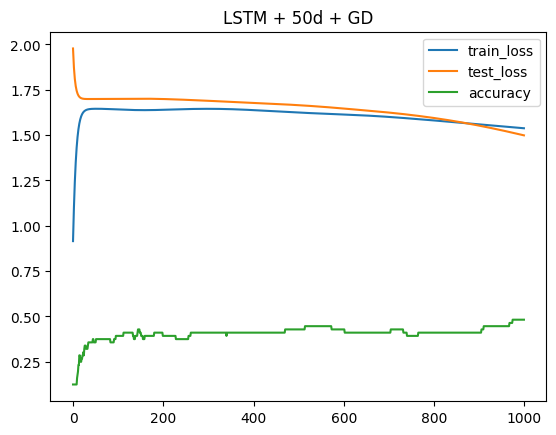

In [34]:
x = np.arange(1000)
plt.plot(x,train_loss, label = 'train_loss')
plt.plot(x,test_loss, label = 'test_loss')
plt.plot(x,accuracy, label = 'accuracy')
plt.legend()
plt.title("LSTM + 50d + GD")

In [35]:
# 100d + SGD 경사하강법

lstm = LSTM(0.05, 4, 100, d100)
correct = 0
train_loss =[]
test_loss = []
accuracy = []
for j in range(1000):
    c = list(zip(train_for_vec, train_label))
    random.shuffle(c)
    train_for_vec, train_label = zip(*c)
    train_label = np.array(train_label)
    for i in range(132//4):
        loss = lstm.SGD(train_for_vec[i*4:(i+1)*4], train_label[i*4:(i+1)*4])
        if i==132//4-1:
            train_loss.append(loss)
    for i in range(56//4):
        out = lstm.SGD_forward_only(test_for_vec[i*4:(i+1)*4], test_label[i*4:(i+1)*4])
        correct += np.sum(np.argmax(out, axis =0) == np.argmax(test_label[i*4:(i+1)*4],axis=1))
        if i == 56//4-1:
            loss = lstm.SGD(test_for_vec[i*4:(i+1)*4], test_label[i*4:(i+1)*4])
            test_loss.append(loss)
    print(j+1,"번째 iter :",train_loss[j])
    print("Accuracy :",correct/56)
    accuracy.append(correct/56)
    correct = 0

1 번째 iter : 3.3463317216225685
Accuracy : 0.125
2 번째 iter : 3.0379968806239788
Accuracy : 0.125
3 번째 iter : 2.970863873313427
Accuracy : 0.16071428571428573
4 번째 iter : 2.981691361734492
Accuracy : 0.21428571428571427
5 번째 iter : 3.023785965628356
Accuracy : 0.2857142857142857
6 번째 iter : 2.9704253395410714
Accuracy : 0.21428571428571427
7 번째 iter : 2.9864195961516615
Accuracy : 0.23214285714285715
8 번째 iter : 2.938857014312283
Accuracy : 0.23214285714285715
9 번째 iter : 2.9214139374942554
Accuracy : 0.23214285714285715
10 번째 iter : 2.951251527774602
Accuracy : 0.23214285714285715
11 번째 iter : 2.932596174687981
Accuracy : 0.23214285714285715
12 번째 iter : 2.9442205578873812
Accuracy : 0.23214285714285715
13 번째 iter : 2.9064755910009135
Accuracy : 0.25
14 번째 iter : 2.99285487523103
Accuracy : 0.23214285714285715
15 번째 iter : 2.979145897759061
Accuracy : 0.25
16 번째 iter : 2.9851392457277925
Accuracy : 0.25
17 번째 iter : 2.988069882040718
Accuracy : 0.25
18 번째 iter : 2.9433969182254818
Accur

138 번째 iter : 2.978548852182966
Accuracy : 0.25
139 번째 iter : 3.005391343752085
Accuracy : 0.25
140 번째 iter : 2.9644681500056325
Accuracy : 0.25
141 번째 iter : 2.9113435465148134
Accuracy : 0.26785714285714285
142 번째 iter : 2.95348510684207
Accuracy : 0.25
143 번째 iter : 2.8910532980191554
Accuracy : 0.25
144 번째 iter : 2.934054342041068
Accuracy : 0.25
145 번째 iter : 2.8946535273315703
Accuracy : 0.25
146 번째 iter : 2.986550978741363
Accuracy : 0.26785714285714285
147 번째 iter : 2.9234300346081246
Accuracy : 0.25
148 번째 iter : 2.9881154195778987
Accuracy : 0.25
149 번째 iter : 2.9798967160296232
Accuracy : 0.25
150 번째 iter : 2.9199863538927087
Accuracy : 0.25
151 번째 iter : 2.9132981474654853
Accuracy : 0.25
152 번째 iter : 2.996939923695659
Accuracy : 0.23214285714285715
153 번째 iter : 2.9970266587227847
Accuracy : 0.25
154 번째 iter : 2.9387388744916327
Accuracy : 0.23214285714285715
155 번째 iter : 2.9159828704984596
Accuracy : 0.23214285714285715
156 번째 iter : 2.9435453773059037
Accuracy : 0.2321

280 번째 iter : 3.0132826695363413
Accuracy : 0.25
281 번째 iter : 2.8857673733116833
Accuracy : 0.25
282 번째 iter : 2.861240064126615
Accuracy : 0.23214285714285715
283 번째 iter : 2.8652486389528904
Accuracy : 0.23214285714285715
284 번째 iter : 2.9403992574019675
Accuracy : 0.25
285 번째 iter : 2.9139457368091066
Accuracy : 0.23214285714285715
286 번째 iter : 2.906814002426456
Accuracy : 0.25
287 번째 iter : 2.890246916210047
Accuracy : 0.25
288 번째 iter : 2.957166131616405
Accuracy : 0.25
289 번째 iter : 2.928634259566393
Accuracy : 0.23214285714285715
290 번째 iter : 2.94047418125197
Accuracy : 0.26785714285714285
291 번째 iter : 2.909905253830088
Accuracy : 0.25
292 번째 iter : 2.960844321621287
Accuracy : 0.25
293 번째 iter : 2.8870861076115597
Accuracy : 0.25
294 번째 iter : 2.827178779769058
Accuracy : 0.25
295 번째 iter : 2.8809408516721784
Accuracy : 0.23214285714285715
296 번째 iter : 2.8064818698297826
Accuracy : 0.25
297 번째 iter : 2.856154860667106
Accuracy : 0.25
298 번째 iter : 2.8808084805364813
Accura

426 번째 iter : 2.843793813186971
Accuracy : 0.26785714285714285
427 번째 iter : 2.7837587466765363
Accuracy : 0.26785714285714285
428 번째 iter : 2.8141939409995755
Accuracy : 0.26785714285714285
429 번째 iter : 2.7736666027074826
Accuracy : 0.25
430 번째 iter : 2.867073371673717
Accuracy : 0.25
431 번째 iter : 2.8370277512692708
Accuracy : 0.25
432 번째 iter : 2.831824471322247
Accuracy : 0.26785714285714285
433 번째 iter : 2.7414464113353727
Accuracy : 0.26785714285714285
434 번째 iter : 2.765964234343335
Accuracy : 0.26785714285714285
435 번째 iter : 2.729517592556233
Accuracy : 0.26785714285714285
436 번째 iter : 2.7898323331193797
Accuracy : 0.26785714285714285
437 번째 iter : 2.909242887569901
Accuracy : 0.26785714285714285
438 번째 iter : 2.826814548290597
Accuracy : 0.26785714285714285
439 번째 iter : 2.6755485223750837
Accuracy : 0.25
440 번째 iter : 2.678011028074538
Accuracy : 0.26785714285714285
441 번째 iter : 2.738261710870299
Accuracy : 0.23214285714285715
442 번째 iter : 2.938975366143799
Accuracy : 0.

560 번째 iter : 2.623300820304322
Accuracy : 0.30357142857142855
561 번째 iter : 2.8554700509490942
Accuracy : 0.3392857142857143
562 번째 iter : 2.706905998691647
Accuracy : 0.35714285714285715
563 번째 iter : 2.920235321826241
Accuracy : 0.32142857142857145
564 번째 iter : 2.774565981191823
Accuracy : 0.30357142857142855
565 번째 iter : 2.810620523321672
Accuracy : 0.32142857142857145
566 번째 iter : 2.908577265971881
Accuracy : 0.3392857142857143
567 번째 iter : 2.7375923911577913
Accuracy : 0.3392857142857143
568 번째 iter : 2.7875243463863564
Accuracy : 0.32142857142857145
569 번째 iter : 2.7726741151321597
Accuracy : 0.3392857142857143
570 번째 iter : 2.799465553931924
Accuracy : 0.3392857142857143
571 번째 iter : 2.8762123247007865
Accuracy : 0.3392857142857143
572 번째 iter : 2.689830019747571
Accuracy : 0.35714285714285715
573 번째 iter : 2.7804799664897497
Accuracy : 0.3392857142857143
574 번째 iter : 2.8074336141209315
Accuracy : 0.3392857142857143
575 번째 iter : 2.8049556869842323
Accuracy : 0.3571428571

697 번째 iter : 2.6267019144564183
Accuracy : 0.39285714285714285
698 번째 iter : 2.878984116278425
Accuracy : 0.39285714285714285
699 번째 iter : 2.7053589337184363
Accuracy : 0.375
700 번째 iter : 2.525983980357146
Accuracy : 0.375
701 번째 iter : 2.573708050283393
Accuracy : 0.39285714285714285
702 번째 iter : 2.7355432641429864
Accuracy : 0.39285714285714285
703 번째 iter : 2.5442610603059514
Accuracy : 0.39285714285714285
704 번째 iter : 2.648581529009526
Accuracy : 0.39285714285714285
705 번째 iter : 2.7123093364893873
Accuracy : 0.375
706 번째 iter : 2.69115485088364
Accuracy : 0.39285714285714285
707 번째 iter : 2.7320442723184
Accuracy : 0.4107142857142857
708 번째 iter : 2.8130291206227342
Accuracy : 0.4107142857142857
709 번째 iter : 2.568690366360298
Accuracy : 0.375
710 번째 iter : 2.62186984378166
Accuracy : 0.375
711 번째 iter : 2.5960960877692907
Accuracy : 0.375
712 번째 iter : 2.7230410233052442
Accuracy : 0.35714285714285715
713 번째 iter : 2.7652037585244877
Accuracy : 0.44642857142857145
714 번째 ite

836 번째 iter : 2.6559526896110377
Accuracy : 0.5357142857142857
837 번째 iter : 2.7053851265368323
Accuracy : 0.5178571428571429
838 번째 iter : 2.608977605763259
Accuracy : 0.5178571428571429
839 번째 iter : 2.8131309018481248
Accuracy : 0.5357142857142857
840 번째 iter : 2.6570267506914207
Accuracy : 0.5357142857142857
841 번째 iter : 2.45983258042421
Accuracy : 0.5178571428571429
842 번째 iter : 2.650497839475642
Accuracy : 0.5357142857142857
843 번째 iter : 2.427264362866821
Accuracy : 0.5357142857142857
844 번째 iter : 2.7514276346661277
Accuracy : 0.5535714285714286
845 번째 iter : 2.6081470092925296
Accuracy : 0.5178571428571429
846 번째 iter : 2.7099415751058764
Accuracy : 0.5178571428571429
847 번째 iter : 2.7335753362657966
Accuracy : 0.5178571428571429
848 번째 iter : 2.7203322255829856
Accuracy : 0.5357142857142857
849 번째 iter : 2.6610233472417515
Accuracy : 0.5357142857142857
850 번째 iter : 2.683046596939451
Accuracy : 0.5178571428571429
851 번째 iter : 2.6110824352204154
Accuracy : 0.535714285714285

972 번째 iter : 2.6009845189564116
Accuracy : 0.625
973 번째 iter : 2.608840680912393
Accuracy : 0.625
974 번째 iter : 2.325945694512187
Accuracy : 0.5892857142857143
975 번째 iter : 2.431964416151809
Accuracy : 0.6428571428571429
976 번째 iter : 2.548522247163053
Accuracy : 0.625
977 번째 iter : 2.7394629321031427
Accuracy : 0.625
978 번째 iter : 2.3746222159027113
Accuracy : 0.625
979 번째 iter : 2.763842365117239
Accuracy : 0.6071428571428571
980 번째 iter : 2.704120198066673
Accuracy : 0.6428571428571429
981 번째 iter : 2.5575921753048965
Accuracy : 0.6071428571428571
982 번째 iter : 2.4163563558361414
Accuracy : 0.625
983 번째 iter : 2.685558085530873
Accuracy : 0.6071428571428571
984 번째 iter : 2.354829586890909
Accuracy : 0.6071428571428571
985 번째 iter : 2.7051256783865476
Accuracy : 0.625
986 번째 iter : 2.804227243660056
Accuracy : 0.6071428571428571
987 번째 iter : 2.440671357743857
Accuracy : 0.625
988 번째 iter : 2.713829691737261
Accuracy : 0.625
989 번째 iter : 2.399247520767436
Accuracy : 0.625
990 번째 i

Text(0.5, 1.0, 'LSTM + 100d + SGD')

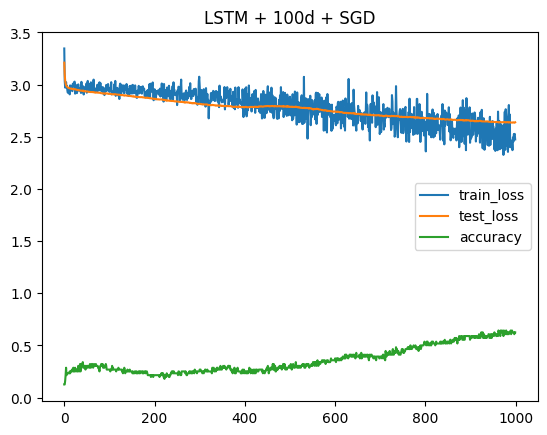

In [36]:
x = np.arange(1000)
plt.plot(x,train_loss, label = 'train_loss')
plt.plot(x,test_loss, label = 'test_loss')
plt.plot(x,accuracy, label = 'accuracy')
plt.legend()
plt.title("LSTM + 100d + SGD")

In [38]:
# 50d + SGD + Dropout 경사하강법

lstm = LSTM(0.05, 4, 50, d50, 0.5)
correct = 0
train_loss =[]
test_loss = []
accuracy = []
for j in range(1000):
    c = list(zip(train_for_vec, train_label))
    random.shuffle(c)
    train_for_vec, train_label = zip(*c)
    train_label = np.array(train_label)
    for i in range(132//4):
        loss = lstm.SGD(train_for_vec[i*4:(i+1)*4], train_label[i*4:(i+1)*4])
        if i==132//4-1:
            train_loss.append(loss)
    for i in range(56//4):
        out = lstm.SGD_forward_only(test_for_vec[i*4:(i+1)*4], test_label[i*4:(i+1)*4])
        correct += np.sum(np.argmax(out, axis =0) == np.argmax(test_label[i*4:(i+1)*4],axis=1))
        if i == 56//4-1:
            loss = lstm.SGD(test_for_vec[i*4:(i+1)*4], test_label[i*4:(i+1)*4])
            test_loss.append(loss)
    print(j+1,"번째 iter :",train_loss[j])
    print("Accuracy :",correct/56)
    accuracy.append(correct/56)
    correct = 0

1 번째 iter : 2.6330050713230344
Accuracy : 0.2857142857142857
2 번째 iter : 3.012455949879498
Accuracy : 0.2857142857142857
3 번째 iter : 3.004670342779196
Accuracy : 0.25
4 번째 iter : 2.997430406808453
Accuracy : 0.35714285714285715
5 번째 iter : 2.9681730772788404
Accuracy : 0.32142857142857145
6 번째 iter : 2.9601021322283496
Accuracy : 0.39285714285714285
7 번째 iter : 3.0219382265157186
Accuracy : 0.26785714285714285
8 번째 iter : 2.9848921357395652
Accuracy : 0.2857142857142857
9 번째 iter : 2.972877877590657
Accuracy : 0.2857142857142857
10 번째 iter : 3.0054376180718503
Accuracy : 0.32142857142857145
11 번째 iter : 2.919883242223228
Accuracy : 0.30357142857142855
12 번째 iter : 3.01524653473735
Accuracy : 0.25
13 번째 iter : 2.971496230681328
Accuracy : 0.2857142857142857
14 번째 iter : 2.9485893947452473
Accuracy : 0.32142857142857145
15 번째 iter : 2.9743181008276887
Accuracy : 0.30357142857142855
16 번째 iter : 2.953804008242888
Accuracy : 0.3392857142857143
17 번째 iter : 2.9513507299698865
Accuracy : 0.3

139 번째 iter : 2.8684677906944165
Accuracy : 0.2857142857142857
140 번째 iter : 2.9639332995228624
Accuracy : 0.4107142857142857
141 번째 iter : 3.0341273275338243
Accuracy : 0.30357142857142855
142 번째 iter : 2.8940162138239574
Accuracy : 0.39285714285714285
143 번째 iter : 2.917141692459299
Accuracy : 0.35714285714285715
144 번째 iter : 3.0070344278673398
Accuracy : 0.2857142857142857
145 번째 iter : 2.926660825754699
Accuracy : 0.30357142857142855
146 번째 iter : 3.0486762300506194
Accuracy : 0.35714285714285715
147 번째 iter : 3.021691034626789
Accuracy : 0.35714285714285715
148 번째 iter : 2.9172060565985927
Accuracy : 0.4107142857142857
149 번째 iter : 2.8910016528045492
Accuracy : 0.4107142857142857
150 번째 iter : 2.9416726845334744
Accuracy : 0.375
151 번째 iter : 3.0380965372232067
Accuracy : 0.35714285714285715
152 번째 iter : 3.011999831636941
Accuracy : 0.35714285714285715
153 번째 iter : 2.974771973396298
Accuracy : 0.39285714285714285
154 번째 iter : 3.02872750986074
Accuracy : 0.26785714285714285
15

273 번째 iter : 2.9077891086910914
Accuracy : 0.35714285714285715
274 번째 iter : 2.8524558627994288
Accuracy : 0.4107142857142857
275 번째 iter : 2.9634484522356304
Accuracy : 0.35714285714285715
276 번째 iter : 3.061415911259449
Accuracy : 0.39285714285714285
277 번째 iter : 2.9093624341570505
Accuracy : 0.44642857142857145
278 번째 iter : 2.9531532345074765
Accuracy : 0.3392857142857143
279 번째 iter : 2.8131810975500517
Accuracy : 0.375
280 번째 iter : 2.9524778666941134
Accuracy : 0.35714285714285715
281 번째 iter : 2.9930741161107317
Accuracy : 0.4107142857142857
282 번째 iter : 2.9387770948249816
Accuracy : 0.2857142857142857
283 번째 iter : 2.9839639581323887
Accuracy : 0.42857142857142855
284 번째 iter : 2.8770508887938373
Accuracy : 0.39285714285714285
285 번째 iter : 2.895275701127545
Accuracy : 0.42857142857142855
286 번째 iter : 3.0496391813325863
Accuracy : 0.3392857142857143
287 번째 iter : 2.9182247997521586
Accuracy : 0.3392857142857143
288 번째 iter : 2.9470257361993246
Accuracy : 0.375
289 번째 iter 

411 번째 iter : 2.9122823239275366
Accuracy : 0.3392857142857143
412 번째 iter : 2.9576328097768143
Accuracy : 0.32142857142857145
413 번째 iter : 2.900537666430398
Accuracy : 0.4107142857142857
414 번째 iter : 2.7427094489219197
Accuracy : 0.35714285714285715
415 번째 iter : 3.030551937567539
Accuracy : 0.42857142857142855
416 번째 iter : 2.973235024183397
Accuracy : 0.42857142857142855
417 번째 iter : 2.822009104324737
Accuracy : 0.35714285714285715
418 번째 iter : 2.921911436397243
Accuracy : 0.4107142857142857
419 번째 iter : 2.8614602898757067
Accuracy : 0.44642857142857145
420 번째 iter : 2.9618797244225012
Accuracy : 0.35714285714285715
421 번째 iter : 2.746092029515575
Accuracy : 0.375
422 번째 iter : 2.9669298564496502
Accuracy : 0.42857142857142855
423 번째 iter : 2.9762934692949887
Accuracy : 0.4107142857142857
424 번째 iter : 2.9243551863491
Accuracy : 0.375
425 번째 iter : 2.957903906525827
Accuracy : 0.44642857142857145
426 번째 iter : 2.8431446542899503
Accuracy : 0.4107142857142857
427 번째 iter : 3.083

545 번째 iter : 3.0451394299666115
Accuracy : 0.32142857142857145
546 번째 iter : 2.944332299654148
Accuracy : 0.4107142857142857
547 번째 iter : 2.780438645527012
Accuracy : 0.2857142857142857
548 번째 iter : 3.03589810609083
Accuracy : 0.39285714285714285
549 번째 iter : 2.817263954475676
Accuracy : 0.4107142857142857
550 번째 iter : 2.9540528883555632
Accuracy : 0.35714285714285715
551 번째 iter : 3.063500030489501
Accuracy : 0.375
552 번째 iter : 2.974102937018955
Accuracy : 0.44642857142857145
553 번째 iter : 3.0129822208692474
Accuracy : 0.35714285714285715
554 번째 iter : 2.8243092028186103
Accuracy : 0.35714285714285715
555 번째 iter : 2.781893484235243
Accuracy : 0.375
556 번째 iter : 2.9385445219225876
Accuracy : 0.4107142857142857
557 번째 iter : 2.9057554950376736
Accuracy : 0.39285714285714285
558 번째 iter : 2.9427548034268387
Accuracy : 0.4107142857142857
559 번째 iter : 2.720768184467093
Accuracy : 0.375
560 번째 iter : 2.8305250119733456
Accuracy : 0.39285714285714285
561 번째 iter : 2.9817500034481537

680 번째 iter : 2.9877161465468123
Accuracy : 0.35714285714285715
681 번째 iter : 3.060070369053708
Accuracy : 0.39285714285714285
682 번째 iter : 2.8862634710775437
Accuracy : 0.39285714285714285
683 번째 iter : 2.905725547509271
Accuracy : 0.4107142857142857
684 번째 iter : 2.9123017820631807
Accuracy : 0.4107142857142857
685 번째 iter : 2.8323205147139197
Accuracy : 0.32142857142857145
686 번째 iter : 2.8250987835471113
Accuracy : 0.375
687 번째 iter : 2.872478302448763
Accuracy : 0.39285714285714285
688 번째 iter : 2.679625548807288
Accuracy : 0.2857142857142857
689 번째 iter : 2.69919575441424
Accuracy : 0.35714285714285715
690 번째 iter : 2.704968205809032
Accuracy : 0.3392857142857143
691 번째 iter : 2.688401270405884
Accuracy : 0.35714285714285715
692 번째 iter : 2.7608388417854317
Accuracy : 0.35714285714285715
693 번째 iter : 2.8300223738077626
Accuracy : 0.3392857142857143
694 번째 iter : 2.5867981018346855
Accuracy : 0.32142857142857145
695 번째 iter : 2.6742640759808785
Accuracy : 0.3392857142857143
696 

815 번째 iter : 2.944779384435842
Accuracy : 0.26785714285714285
816 번째 iter : 2.841309940879722
Accuracy : 0.39285714285714285
817 번째 iter : 2.755494530047623
Accuracy : 0.32142857142857145
818 번째 iter : 2.803166541449141
Accuracy : 0.35714285714285715
819 번째 iter : 2.880909190304261
Accuracy : 0.35714285714285715
820 번째 iter : 3.0906894798385123
Accuracy : 0.39285714285714285
821 번째 iter : 2.882573673160085
Accuracy : 0.35714285714285715
822 번째 iter : 2.963877627131373
Accuracy : 0.39285714285714285
823 번째 iter : 2.842858702975113
Accuracy : 0.375
824 번째 iter : 2.570417879413143
Accuracy : 0.30357142857142855
825 번째 iter : 3.0228460892592337
Accuracy : 0.375
826 번째 iter : 2.883257651491717
Accuracy : 0.32142857142857145
827 번째 iter : 2.926726572575169
Accuracy : 0.375
828 번째 iter : 2.8504779184679765
Accuracy : 0.30357142857142855
829 번째 iter : 2.9265456208970013
Accuracy : 0.375
830 번째 iter : 2.8641381289473227
Accuracy : 0.35714285714285715
831 번째 iter : 2.686780211082933
Accuracy : 

951 번째 iter : 2.9001518160606112
Accuracy : 0.3392857142857143
952 번째 iter : 2.9358132719273544
Accuracy : 0.30357142857142855
953 번째 iter : 2.969337428721062
Accuracy : 0.26785714285714285
954 번째 iter : 2.719721521495122
Accuracy : 0.30357142857142855
955 번째 iter : 2.880082954938053
Accuracy : 0.30357142857142855
956 번째 iter : 2.6137756409839654
Accuracy : 0.4107142857142857
957 번째 iter : 2.837338482240428
Accuracy : 0.35714285714285715
958 번째 iter : 2.7203573307199522
Accuracy : 0.3392857142857143
959 번째 iter : 2.999862420911957
Accuracy : 0.30357142857142855
960 번째 iter : 2.447653222954772
Accuracy : 0.375
961 번째 iter : 2.665232798931406
Accuracy : 0.2857142857142857
962 번째 iter : 2.754672303124666
Accuracy : 0.35714285714285715
963 번째 iter : 3.029822168586324
Accuracy : 0.3392857142857143
964 번째 iter : 2.5541541807962105
Accuracy : 0.35714285714285715
965 번째 iter : 2.997523807994414
Accuracy : 0.44642857142857145
966 번째 iter : 2.940048677723677
Accuracy : 0.3392857142857143
967 번째 

Text(0.5, 1.0, 'LSTM + 50d + SGD + Dropout')

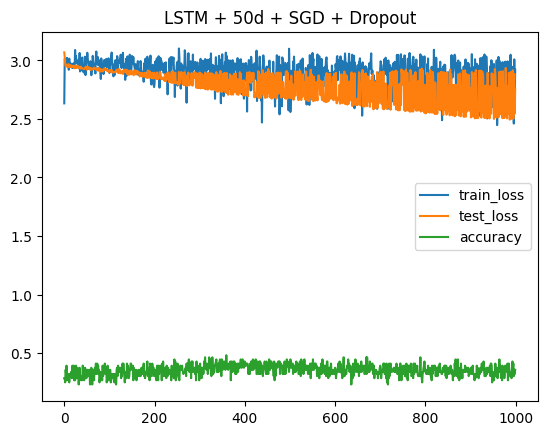

In [39]:
x = np.arange(1000)
plt.plot(x,train_loss, label = 'train_loss')
plt.plot(x,test_loss, label = 'test_loss')
plt.plot(x,accuracy, label = 'accuracy')
plt.legend()
plt.title("LSTM + 50d + SGD + Dropout")